In [10]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")
library(corrplot)
library(circlize)

In [11]:
library(ComplexHeatmap)


In [12]:
library(svglite)

In [13]:
library(ggrepel)

In [14]:
source('../src/common_functions.R')

In [15]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

# Enrichment of differentially expressed proteins and transcripts

Compare DE genes and DE proteins and run enrichment for all

# Create DE df

# GOSEQ

In [16]:
df_all = read_csv(file.path('DE_results', 'MED4_all_FC_results.csv'))

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 53457 Columns: 34
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (22): contrast, protein_id, Assay, contrast1, Name, gene, locus_tag, old...
dbl  (7): logFC, AveExpr, pvalue, padj, start, end, gene_length
lgl  (5): Note, exception, down, up, is_de

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [17]:
goseq_res = read_csv(file.path('DE_results', 'HOT1A3_GOSEQ_results.csv'))

Rows: 10058 Columns: 17
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (12): category, type, enrich, contrast, organism, main, sub, module, Cat...
dbl  (5): over_represented_pvalue, padj, under_represented_pvalue, numDEInCa...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [18]:
category.order

[1] "Photosynthesis/Carbon fixation"          
 [2] "high light inducible"                    
 [3] "Energy/Carbohydrate/Glycan"              
 [4] "AA/Nucleotide;Energy/Carbohydrate/Glycan"
 [5] "AA/Nucleotide"                           
 [6] "Nitrogen metabolism"                     
 [7] "Metabolism"                              
 [8] "Membrane transport"                      
 [9] "Motility"                                
[10] "Env. Info/Cellular Process"              
[11] "Genetic Info"                            
[12] "Other"                                   
[13] "Uncharacterized"

In [19]:
#goseq_res = goseq_res %>%
#    mutate(Category = factor(Category, levels=category.order))


In [20]:
head(goseq_res)

category,over_represented_pvalue,padj,under_represented_pvalue,numDEInCat,numInCat,type,enrich,contrast,organism,main,sub,module,Category,PATH,pathway,path
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
09122,2.962018e-11,7.997449e-10,1.0000000,25,76,down,sub,C2vsC1_prot,HOT1A3,09120 Genetic Information Processing,09122 Translation,Translation,Genetic Info,09122 Translation,Translation,NA
09182,2.954313e-04,3.988323e-03,0.9998623,47,380,down,sub,C2vsC1_prot,HOT1A3,09180 Brite Hierarchies,09182 Protein families: genetic information processing,Protein families: genetic information processing,Genetic Info,09182 Protein families: genetic information processing,Protein families: genetic information processing,NA
09105,7.756781e-04,6.981103e-03,0.9996844,26,170,down,sub,C2vsC1_prot,HOT1A3,09100 Metabolism,09105 Amino acid metabolism,Amino acid,AA/Nucleotide,09105 Amino acid metabolism,Amino acid metabolism,NA
09102,4.319859e-03,2.334114e-02,0.9983626,16,96,down,sub,C2vsC1_prot,HOT1A3,09100 Metabolism,09102 Energy metabolism,Energy,Energy/Carbohydrate/Glycan,09102 Energy metabolism,Energy metabolism,NA
09142,4.322433e-03,2.334114e-02,0.9987031,11,54,down,sub,C2vsC1_prot,HOT1A3,09140 Cellular Processes,09142 Cell motility,Cell motility,Motility,09142 Cell motility,Cell motility,NA
09132,3.774030e-02,1.698314e-01,0.9821703,14,99,down,sub,C2vsC1_prot,HOT1A3,09130 Environmental Information Processing,09132 Signal transduction,Signal transduction,Env. Info/Cellular Process,09132 Signal transduction,Signal transduction,NA


In [21]:
goseq_meta = goseq_res %>% distinct(contrast) %>% 
    separate_wider_delim(contrast, "_", names = c(NA, "Assay"), cols_remove = FALSE) %>%
    mutate(Group = case_when(
        str_detect(contrast, "C")~ "Coculture", 
        str_detect(contrast, "P3|P5|LATEvsP")~ "Axenic late", 
        TRUE~ "Axenic"
    )) %>% 
    mutate(
        Group = factor(Group, levels=c("Coculture", "Axenic", "Axenic late")),
        Assay = factor(Assay, levels=c("rna", "prot"))
          ) %>%
    arrange(Group, Assay, contrast) %>%
    column_to_rownames('contrast') 
goseq_meta 

,Assay,Group
,<fct>,<fct>
C1vsA1_rna,rna,Coculture
C2vsC1_rna,rna,Coculture
C3vsC1_rna,rna,Coculture
C3vsC2_rna,rna,Coculture
C4vsC1_rna,rna,Coculture
C4vsC3_rna,rna,Coculture
C5vsC1_rna,rna,Coculture
C5vsC4_rna,rna,Coculture
LATEvsC1_rna,rna,Coculture


In [22]:
options(repr.plot.width = 15, repr.plot.height = 15, repr.plot.res = 300)

In [23]:
goseq_pal_up_fun = colorRamp2(c(0,-log10(0.05), 6), c("white", 'pink', "red"))
pupgoseq = goseq_pal_up_fun(seq(0, 6))
goseq_pal_down_fun = colorRamp2(c(0,-log10(0.05), 6), c("white", 'lightblue', "blue"))
pdowngoseq = goseq_pal_down_fun(seq(0, 6))

In [24]:
goseq_pal_updown_fun = colorRamp2(c(-6, log10(0.05), 0,-log10(0.05), 6), c('blue', 'lightblue', "white", 'pink', "red"))


In [25]:
goseq_pal_fc_fun = colorRamp2(c(-5,-2,-1, 0, 1,2, 5), rev(RColorBrewer::brewer.pal(7, "BrBG")))
pfcgoseq = goseq_pal_fc_fun(seq(-10, 10, length.out = 20))
#pfcgoseq = goseq_pal_up_fun(c(-5, -2, 0, 2, 5))
#show_col(pfcgoseq)

In [26]:
group_pal = c(Coculture='darkgreen', Axenic='#A6BB8D','Axenic late'='darkred')


In [27]:
coclture_assays = goseq_meta %>% filter(Group == "Coculture") %>% row.names()

In [28]:
df_all %>%
    filter(
        contrast1 %in% coclture_assays
    ) %>%
  mutate(
      padj = if_else(is.na(padj), 1, padj),
      up = if_else(is.na(up), FALSE, up),
      down = if_else(is.na(down), FALSE, down),
      significant = padj < 0.05,
      significant_up = significant & up,
      significant_down = significant & down,
      
  ) %>% 
  group_by(gene_id) %>%
  summarise(
      is_up = any(significant_up),
      is_down = any(significant_down),
      de_gene = is_up | is_down
  ) %>%
  group_by(
      #Assay,
      de_gene, 
      is_up, 
      is_down
  ) %>%
  summarise(number_of_genes = n()) %>%

tail() %>% t()
  
#t(head(df_all))

`summarise()` has grouped output by 'de_gene', 'is_up'. You can override using the `.groups` argument.


de_gene,0,1,1,1
is_up,0,0,1,1
is_down,0,1,0,1
number_of_genes,478,549,451,377


In [29]:
contrast_list_individual = c(
    "A2vsA1_prot", 
    "A3vsA1_prot",
    "A5vsA1_prot", 
    "A2vsA1_rna", 
    "A3vsA1_rna", 
    
    "A3vsA2_prot", 
    "A5vsA3_prot", 
    
    "C2vsC1_prot", 
    "C3vsC1_prot", 
    "C4vsC1_prot", 
    "C5vsC1_prot", 

    "C2vsC1_rna" , 
    "C3vsC1_rna", 
    "C4vsC1_rna", 
    "C5vsC1_rna", 
    
    "C3vsC2_prot", 
    "C4vsC3_prot", 
    "C5vsC4_prot", 

    "C3vsC2_rna", 
    "C4vsC3_rna", 
    "C5vsC4_rna"
    )
comparison_order_inidividual =c("AX\nvs 1st", "AX\nvs prev", "CC\nvs 1st", "CC\nvs prev")


In [30]:
dput(sort(unique(goseq_res$contrast)))


c("A2vsA1_prot", "A2vsA1_rna", "A3vsA1_prot", "A3vsA1_rna", "A3vsA2_prot", 
"A5vsA1_prot", "A5vsA3_prot", "C1vsA1_rna", "C2vsC1_prot", "C2vsC1_rna", 
"C3vsC1_prot", "C3vsC1_rna", "C3vsC2_prot", "C3vsC2_rna", "C4vsC1_prot", 
"C4vsC1_rna", "C4vsC3_prot", "C4vsC3_rna", "C5vsC1_prot", "C5vsC1_rna", 
"C5vsC4_prot", "C5vsC4_rna", "LATEvsA1_rna", "LATEvsA2_rna", 
"LATEvsA3_rna", "LATEvsC1_prot", "LATEvsC1_rna", "LATEvsC2_prot", 
"LATEvsC2_rna", "LATEvsC3_prot", "LATEvsC3_rna")


[1] 18
structure(1:4, levels = c("AX\nvs 1st", "AX\nvs prev", "CC\nvs 1st", 
"CC\nvs prev"), class = "factor")
[1] AX\nvs 1st  AX\nvs prev CC\nvs 1st  CC\nvs prev
Levels: AX\nvs 1st AX\nvs prev CC\nvs 1st CC\nvs prev


png 
  2

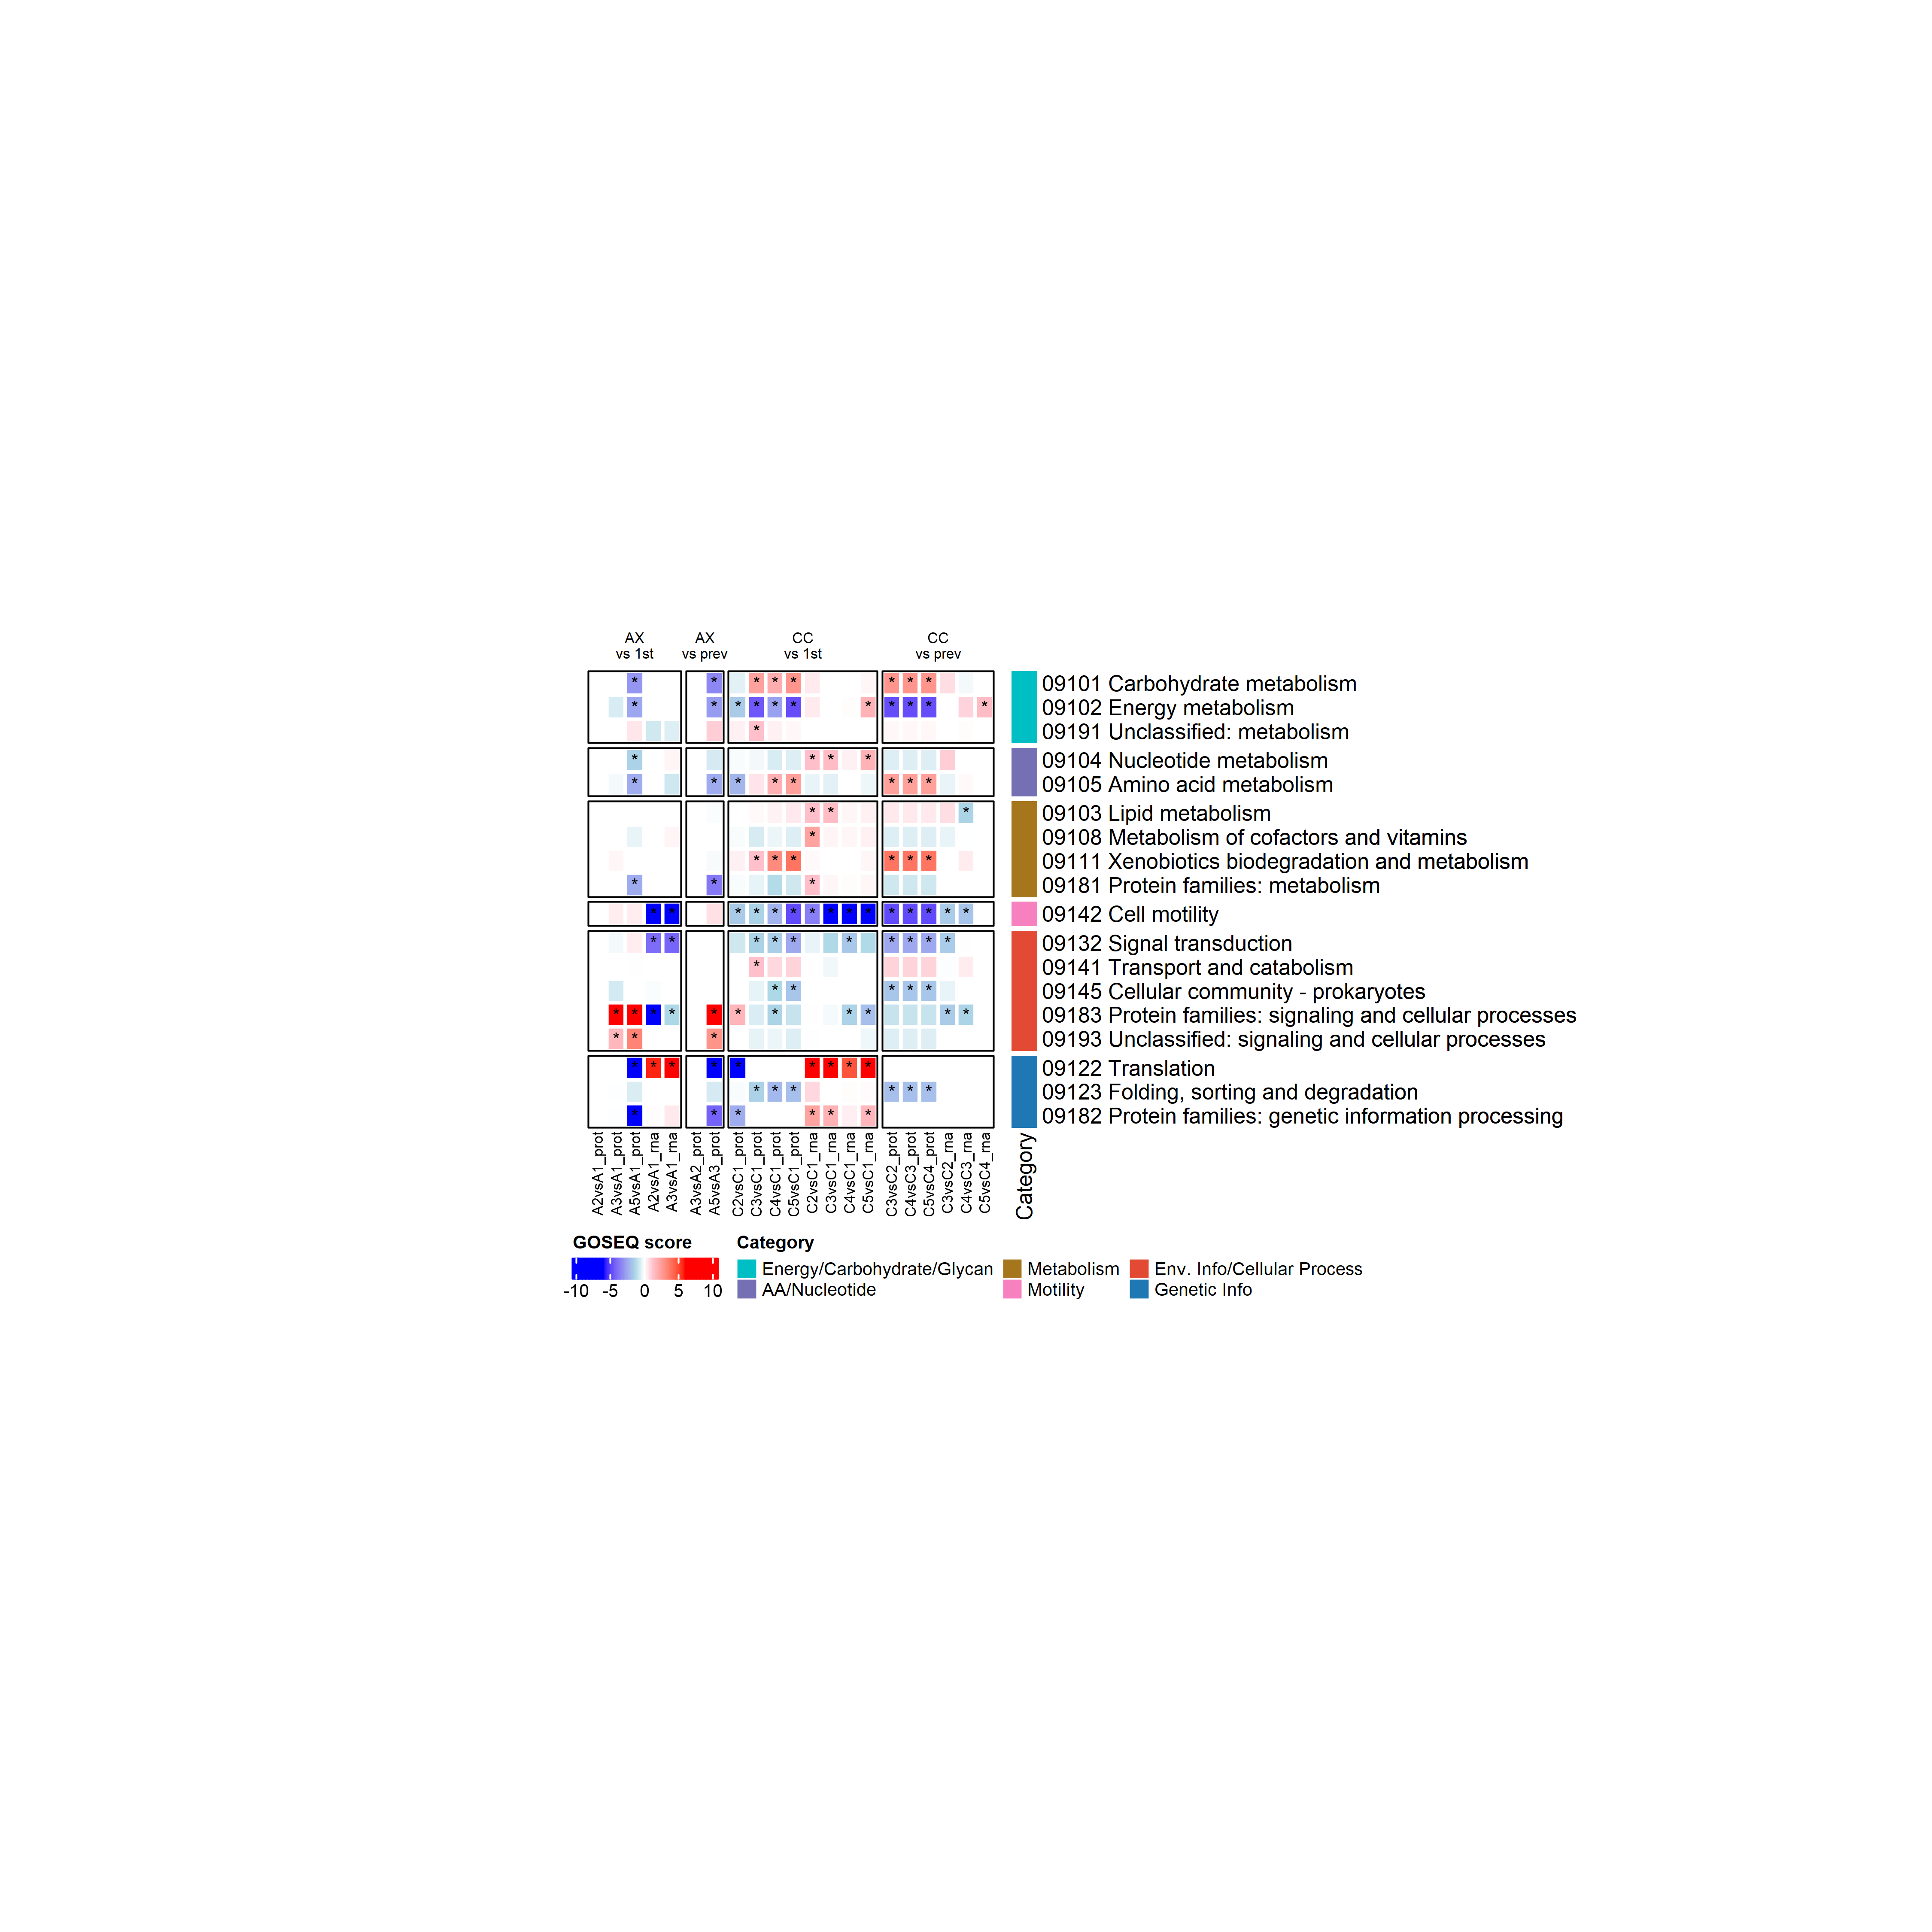

In [31]:
ht = generate_goseq_heatmap_merged(goseq_res, contrast_map_to_label_alt_continues, contrast_list_individual, c('sub'), comparison_order_inidividual)
# Open SVG device
svglite("figures/HOT1A3_goseq_individual_sub.svg", width = 10, height = 8)  # dimensions in inches
# Draw the heatmap
draw(ht)
# Close the device
dev.off()
ht

[1] 46
structure(1:4, levels = c("AX\nvs 1st", "AX\nvs prev", "CC\nvs 1st", 
"CC\nvs prev"), class = "factor")
[1] AX\nvs 1st  AX\nvs prev CC\nvs 1st  CC\nvs prev
Levels: AX\nvs 1st AX\nvs prev CC\nvs 1st CC\nvs prev


png 
  2

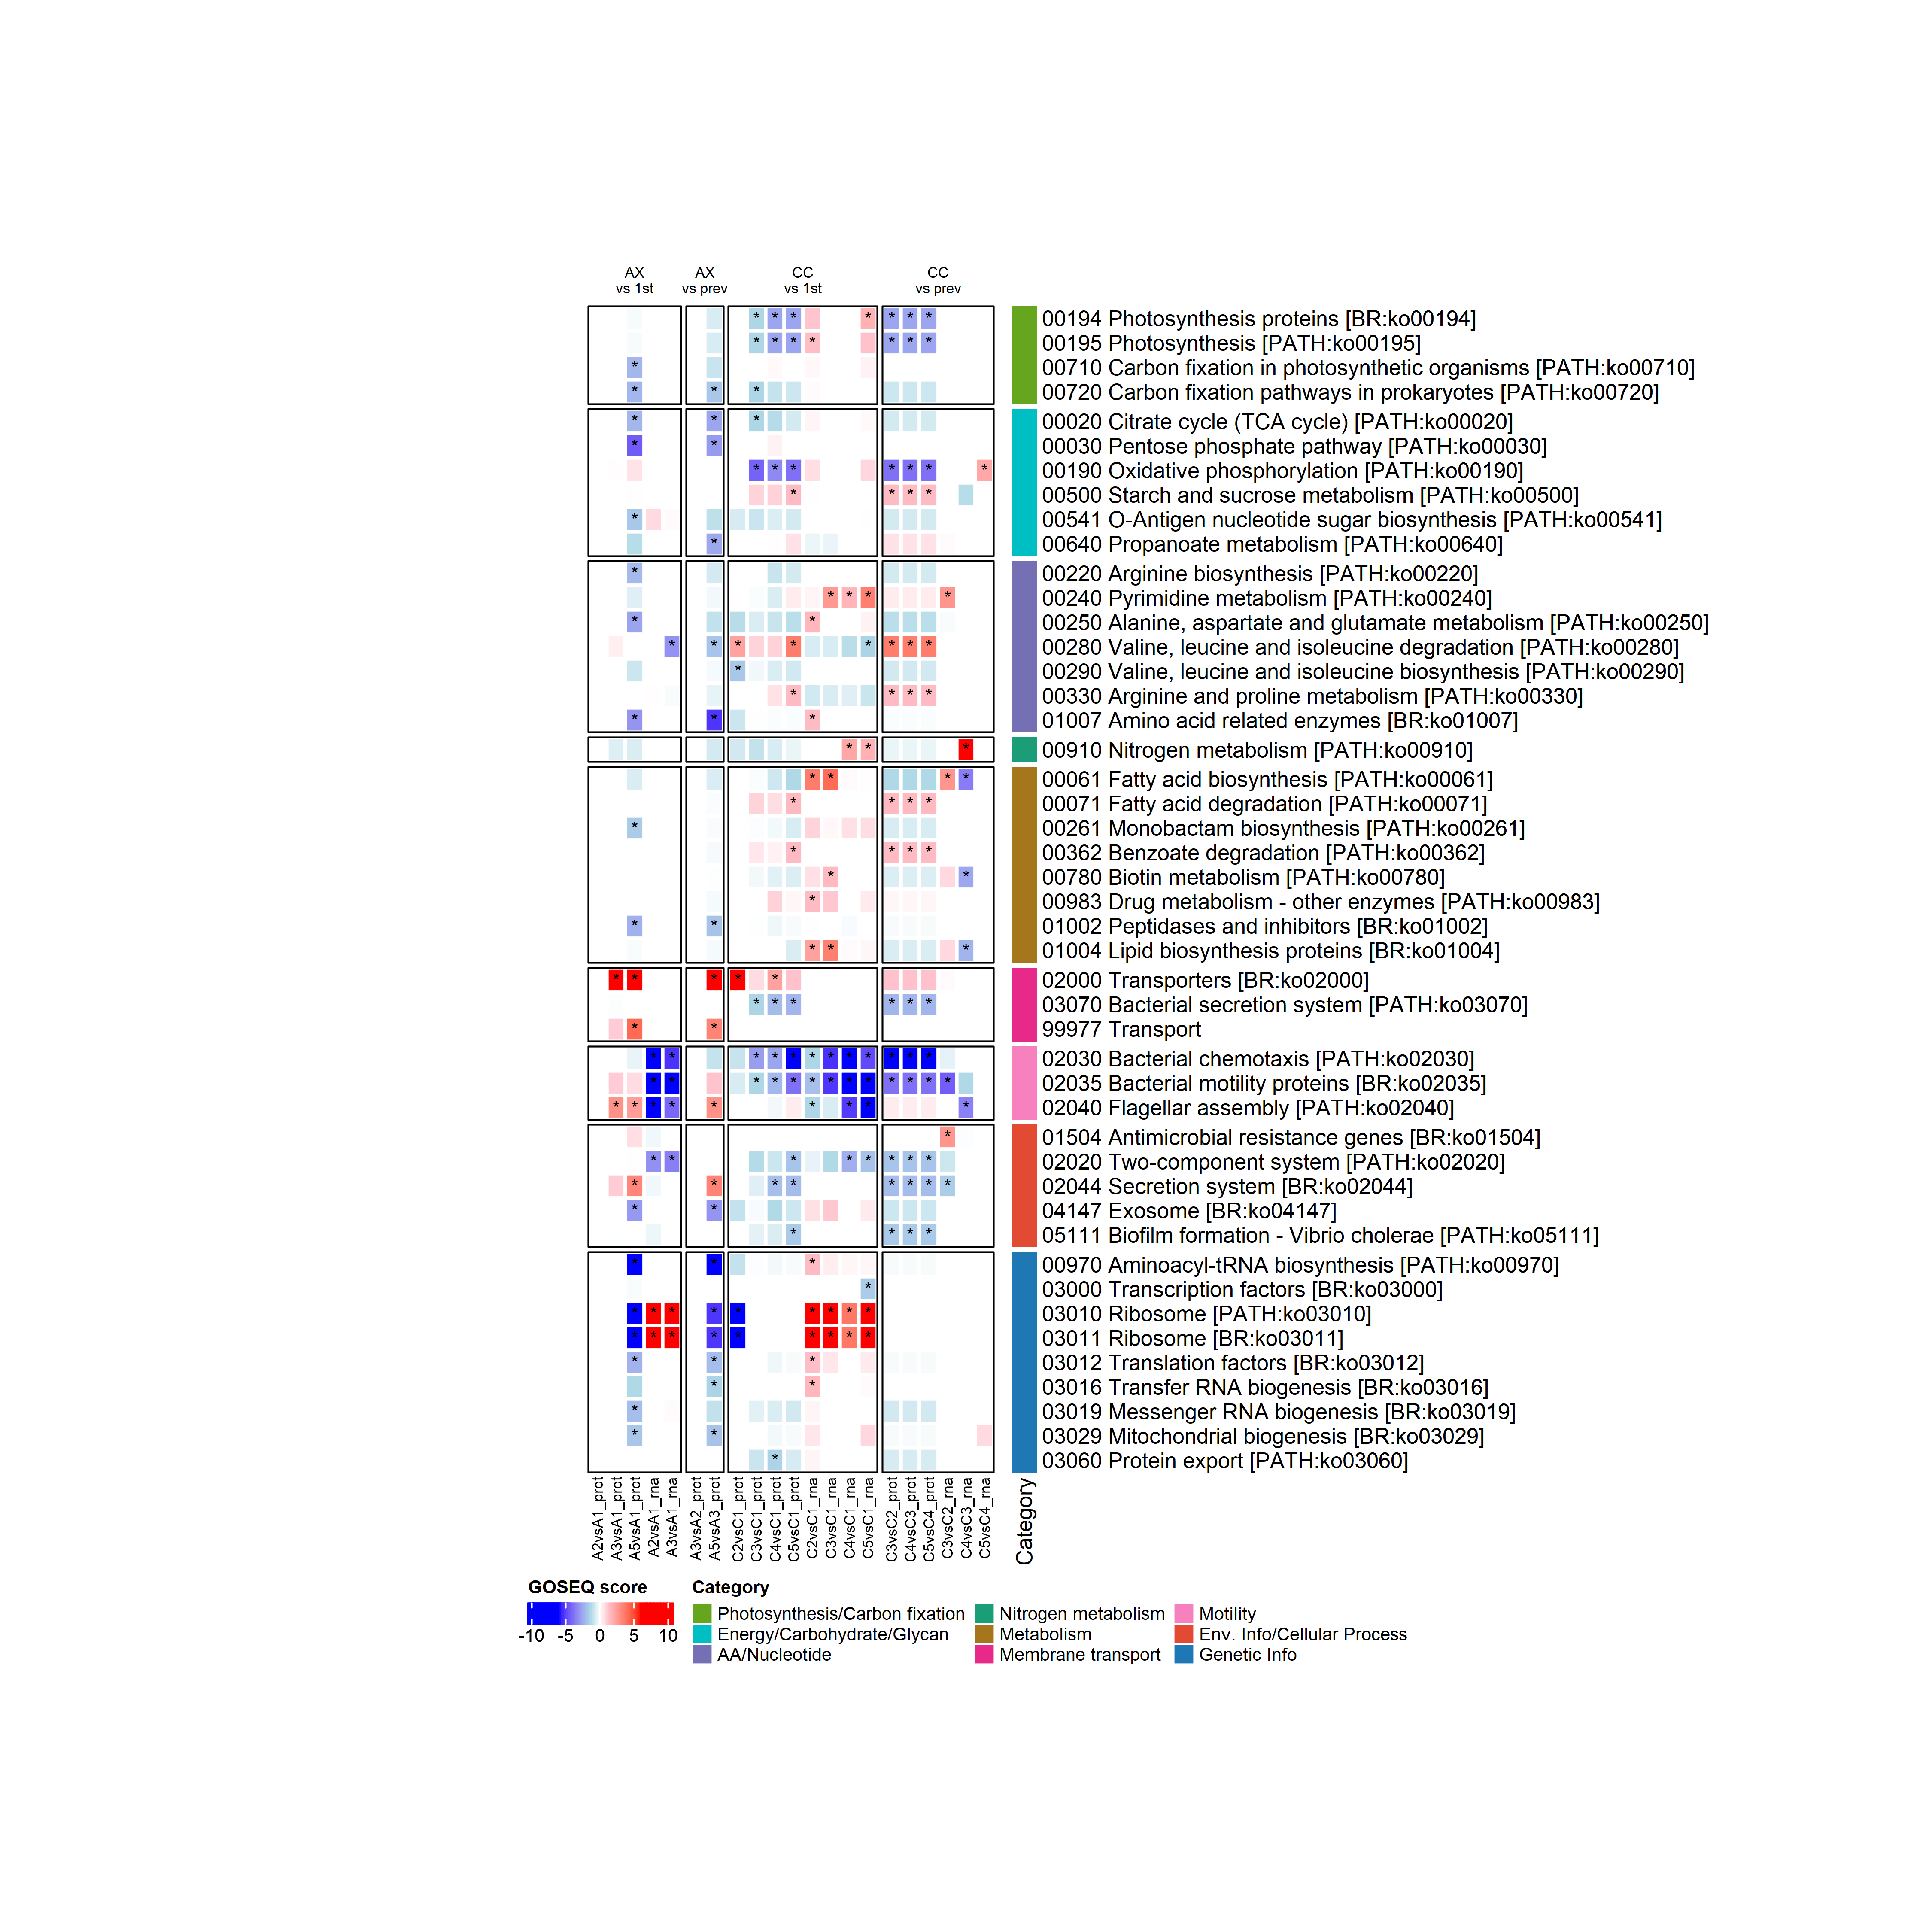

In [32]:
ht = generate_goseq_heatmap_merged(goseq_res, contrast_map_to_label_alt_continues, contrast_list_individual, c('path'), comparison_order_inidividual)
# Open SVG device
svglite("figures/HOT1A3_goseq_individual_path.svg", width = 10, height = 25)  # dimensions in inches
# Draw the heatmap
draw(ht)
# Close the device
dev.off()
ht

In [101]:
dput(unique(goseq_res$Category))

structure(c(10L, 5L, 3L, NA, 9L, 7L, 8L, 12L, 6L, 1L), levels = c("Photosynthesis/Carbon fixation", 
"high light inducible", "Energy/Carbohydrate/Glycan", "AA/Nucleotide;Energy/Carbohydrate/Glycan", 
"AA/Nucleotide", "Nitrogen metabolism", "Metabolism", "Membrane transport", 
"Env. Info/Cellular Process", "Genetic Info", "Other", "Uncharacterized"
), class = "factor")


In [46]:
-log10(0.05)

[1] 1.30103

In [31]:
t(head(goseq_res,2))

category,09122,09182
PATH,09122 Translation,09182 Protein families: genetic information processing
pathway,Translation,Protein families: genetic information processing
over_represented_pvalue,3.468640e-06,6.472609e-04
padj,8.671601e-05,8.090761e-03
under_represented_pvalue,0.9999995,0.9997904
numDEInCat,12,20
numInCat,74,275
main,09120 Genetic Information Processing,09180 Brite Hierarchies
Category,Genetic,Brite
type,down,down


In [29]:
goseq_meta %>% filter(Assay == 'rna') %>%rownames() %>% dput



c("C1vsP1_rna", "C2vsC1_rna", "C3vsC1_rna", "C4vsC1_rna", "C5vsC1_rna", 
"LATEvsC1P1_rna", "P2vsP1_rna")


In [30]:
goseq_meta

,Assay,Group
,<fct>,<fct>
C1vsP1_rna,rna,Coculture
C2vsC1_rna,rna,Coculture
C3vsC1_rna,rna,Coculture
C4vsC1_rna,rna,Coculture
C5vsC1_rna,rna,Coculture
LATEvsC1P1_rna,rna,Coculture
C2vsC1_prot,prot,Coculture
C3vsC1_prot,prot,Coculture
C4vsC1_prot,prot,Coculture


In [31]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [32]:
dput(toppaths)

structure(list(pathway = c("Translation", "Nucleotide metabolism", 
"Membrane transport", "Amino acid metabolism", "Carbohydrate metabolism", 
"Ribosome", "Arginine biosynthesis", "Nitrogen metabolism", "Purine metabolism", 
"ABC transporters", "Alanine, aspartate and glutamate metabolism", 
"Citrate cycle (TCA cycle)", "Energy metabolism", "Metabolism of terpenoids and polyketides", 
"Photosynthesis", "Glyoxylate and dicarboxylate metabolism", 
"Lipid metabolism", "Biosynthesis of other secondary metabolites", 
"Aminoacyl-tRNA biosynthesis", "Fatty acid biosynthesis", "Terpenoid backbone biosynthesis", 
"Metabolism of other amino acids", "Pyrimidine metabolism", "Glutathione metabolism", 
"Histidine metabolism", "Carbon fixation", "Glycolysis / Gluconeogenesis", 
"Pentose phosphate pathway", "Porphyrin metabolism", "Carotenoid biosynthesis"
)), row.names = c(NA, -30L), class = c("tbl_df", "tbl", "data.frame"
))


In [35]:

selected_modules = c(
    'Energy', 'Amino acid', 'Nucleotide', 'Membrane transport'
)
toppaths = goseq_res %>% 
    filter(module %in% selected_modules,
           padj < 0.05) %>% 
    mutate(module=factor(module, levels=selected_modules)) %>%
    distinct(module,pathway) %>%
    arrange(module,pathway)

dput(unique(toppaths$pathway))

c("Carbon fixation", "Energy metabolism", "Nitrogen metabolism", 
"Photosynthesis", "Alanine, aspartate and glutamate metabolism", 
"Amino acid metabolism", "Arginine biosynthesis", "Histidine metabolism", 
"Nucleotide metabolism", "Purine metabolism", "Pyrimidine metabolism", 
"ABC transporters", "Membrane transport")


In [36]:

selected_modules = c(
    'Energy', 'Amino acid', 'Nucleotide', 'Membrane transport'
)

selected_pathways = c(
    "ABC transporters", "Membrane transport", 
    "Nitrogen metabolism", "Carbon fixation", "Photosynthesis", "Energy metabolism",
    "Alanine, aspartate and glutamate metabolism", 
    "Arginine biosynthesis", "Histidine metabolism", "Amino acid metabolism")
toppaths = goseq_res %>% 
    filter(module %in% selected_modules,
           padj < 0.05) %>% 
    mutate(module=factor(module, levels=selected_modules)) %>%
    mutate(pathway=factor(pathway, levels=selected_pathways)) %>%
    distinct(module,pathway) %>%
    arrange(module,pathway)

contrast_list = c("P2vsP1_prot", "C2vsC1_prot", "C3vsC1_prot", "C4vsC1_prot", "C5vsC1_prot", 
  
 "P2vsP1_rna", "C2vsC1_rna", "C3vsC1_rna", "C4vsC1_rna", "C5vsC1_rna")

#days_list = c(C2vsC1_rna = 11, C3vsC1_rna=30, C4vsC1_rna=60, C5vsC1_rna=90,  P2vsP1_rna='Axenic')
days_list = c(
    C2vsC1_rna = 'RNASEQ Day 11', C3vsC1_rna='RNASEQ Day 30', 
    C4vsC1_rna = 'RNASEQ Day 60', C5vsC1_rna='RNASEQ Day 90',  
    P2vsP1_rna = 'RNASEQ Axenic',
    C2vsC1_prot = 'Proteome Day 11', C3vsC1_prot='Proteome Day 30', 
    C4vsC1_prot = 'Proteome Day 60', C5vsC1_prot='Proteome Day 90',  
    P2vsP1_prot = 'Proteome Axenic'
)

column_split_list = c(
    'RNASEQ\nCo-culture', 'RNASEQ\nCo-culture', 
    'RNASEQ\nCo-culture', 'RNASEQ\nCo-culture', 
    'Proteome\nCo-culture', 'Proteome\nCo-culture', 
    'Proteome\nCo-culture', 'Proteome\nCo-culture', 
                       'Axenic', 'Axenic')

# row_ha = rowAnnotation(foo2 = runif(10), ))

module_mat = goseq_res %>% filter(pathway %in% toppaths$pathway) %>% 
    distinct(pathway, module) %>%
    mutate(module=factor(module, levels=selected_modules)) %>%
    mutate(pathway=factor(pathway, levels=selected_pathways)) %>%
    arrange(module,pathway) %>%
    column_to_rownames('pathway') 

# Heatmap(small_mat, name = "mat", col = col_fun, 
#     layer_fun = function(j, i, x, y, width, height, fill) {
#         v = pindex(small_mat, i, j)
#         l = v > 0
#         grid.text(sprintf("%.1f", v[l]), x[l], y[l], gp = gpar(fontsize = 10))
# })

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    filter(contrast %in% contrast_list) %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    mutate(day = days_list[contrast]) %>%
    pivot_wider(names_from = day, values_from = star, id_cols =c(pathway)) %>% 
    mutate(pathway=factor(pathway, levels=selected_pathways)) %>%
#    distinct(pathway) %>%
    arrange(pathway) %>%

    relocate('RNASEQ Day 11', 'RNASEQ Day 30', 'RNASEQ Day 60', 'RNASEQ Day 90',  
             'Proteome Day 11', 'Proteome Day 30', 'Proteome Day 60', 'Proteome Day 90',  
             'RNASEQ Axenic','Proteome Axenic') %>%
   # relocate(all_of(days_list)) %>%
    column_to_rownames('pathway') 
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    filter(contrast %in% contrast_list) %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    mutate(day = days_list[contrast]) %>%
    pivot_wider(names_from = day, values_from = star, id_cols =c(pathway)) %>% 
    mutate(pathway=factor(pathway, levels=selected_pathways)) %>%
#    distinct(pathway) %>%
    arrange(pathway) %>%
#    relocate(contrast_list) %>%
   # relocate(all_of(days_list)) %>%
    relocate('RNASEQ Day 11', 'RNASEQ Day 30', 'RNASEQ Day 60', 'RNASEQ Day 90',  
             'Proteome Day 11', 'Proteome Day 30', 'Proteome Day 60', 'Proteome Day 90',  
             'RNASEQ Axenic','Proteome Axenic') %>%

#    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') 

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type =='up') %>% 
    filter(contrast %in% contrast_list) %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    mutate(day = days_list[contrast]) %>%
    pivot_wider(names_from = day, values_from = score, id_cols =c(pathway)) %>% 
    mutate(pathway=factor(pathway, levels=selected_pathways)) %>%
#    distinct(pathway) %>%
    arrange(pathway) %>%
   # relocate(all_of(days_list)) %>%
#    relocate(contrast_list) %>%
#    relocate(rownames(goseq_meta)) %>%
    relocate('RNASEQ Day 11', 'RNASEQ Day 30', 'RNASEQ Day 60', 'RNASEQ Day 90',  
             'Proteome Day 11', 'Proteome Day 30', 'Proteome Day 60', 'Proteome Day 90',  
             'RNASEQ Axenic','Proteome Axenic') %>%
    #select(-module) %>%
    column_to_rownames('pathway') %>% as.matrix() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    cluster_rows  = FALSE,
    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    row_split = module_mat$module,
    column_split = column_split_list,
    
    #column_split = goseq_meta$Group,
    #column_title_gp = gpar(col = group_pal),
    #column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(7, 'cm'),
    height=unit(5, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    
    #column_title = 'HOT1A3: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)

down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    filter(contrast %in% contrast_list) %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    mutate(day = days_list[contrast]) %>%
    pivot_wider(names_from = day, values_from = score, id_cols =c(pathway)) %>% 
#    relocate(rownames(goseq_meta)) %>%
#    relocate(all_of(days_list)) %>%
#    relocate(contrast_list) %>%
    relocate('RNASEQ Day 11', 'RNASEQ Day 30', 'RNASEQ Day 60', 'RNASEQ Day 90',  
             'Proteome Day 11', 'Proteome Day 30', 'Proteome Day 60', 'Proteome Day 90',  
             'RNASEQ Axenic','Proteome Axenic') %>%
    mutate(pathway=factor(pathway, levels=selected_pathways)) %>%
#    distinct(pathway) %>%
    arrange(pathway) %>%
    column_to_rownames('pathway') %>% as.matrix() %>%
Heatmap(
    name = 'Down Score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    cluster_rows  = FALSE,    
    show_row_dend = FALSE,
    column_split = column_split_list,
    #column_order = rownames(goseq_meta),
    #column_split = goseq_meta$Group,
    #column_title_gp = gpar(col = group_pal),
    #column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(7, 'cm'),
    height=unit(5, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)

ann_mat = Heatmap(
    as.matrix(module_mat), 
    name='Module',
    width=unit(0.5, 'cm'),
    heatmap_legend_param = list(direction = "horizontal", ncol=3),
    col = structure(brewer.pal(length(unique(module_mat$module)), "Set3"), names = selected_modules),
    row_title=FALSE,
)

ht_list = up_mat + down_mat + ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,)

ERROR: Error in attributes(.Data) <- c(attributes(.Data), attrib): 'names' attribute [4] must be the same length as the vector [3]


In [37]:
up_stars

,RNASEQ Day 11,RNASEQ Day 30,RNASEQ Day 60,RNASEQ Day 90,Proteome Day 11,Proteome Day 30,Proteome Day 60,Proteome Day 90,RNASEQ Axenic,Proteome Axenic
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ABC transporters,,,,,*,,*,*,,
Membrane transport,,,,,*,,*,*,,
Nitrogen metabolism,,,,,*,*,*,*,,*
Carbon fixation,,,,,,,,,,
Photosynthesis,,,,,,,,,,
Energy metabolism,,,,,,,,,,
"Alanine, aspartate and glutamate metabolism",,,,,*,,,,,
Arginine biosynthesis,,,,,*,*,,,,*
Histidine metabolism,,,,,,,,,,


In [38]:
toppaths = goseq_res %>% 
    filter(#enrich=='sub', 
           padj < 0.05) %>% 
    distinct(module)
toppaths

module
<chr>
Translation
Nucleotide
Membrane transport
Amino acid
Carbohydrate
Energy
terpenoids and polyketides
Lipid
other secondary metabolites


No legend element is put in the last 1 column under `ncol = 3`, maybe
you should set `by_row = TRUE`? Reset `ncol` to 2.

No legend element is put in the last 1 column under `ncol = 3`, maybe
you should set `by_row = TRUE`? Reset `ncol` to 2.

No legend element is put in the last 1 column under `ncol = 3`, maybe
you should set `by_row = TRUE`? Reset `ncol` to 2.



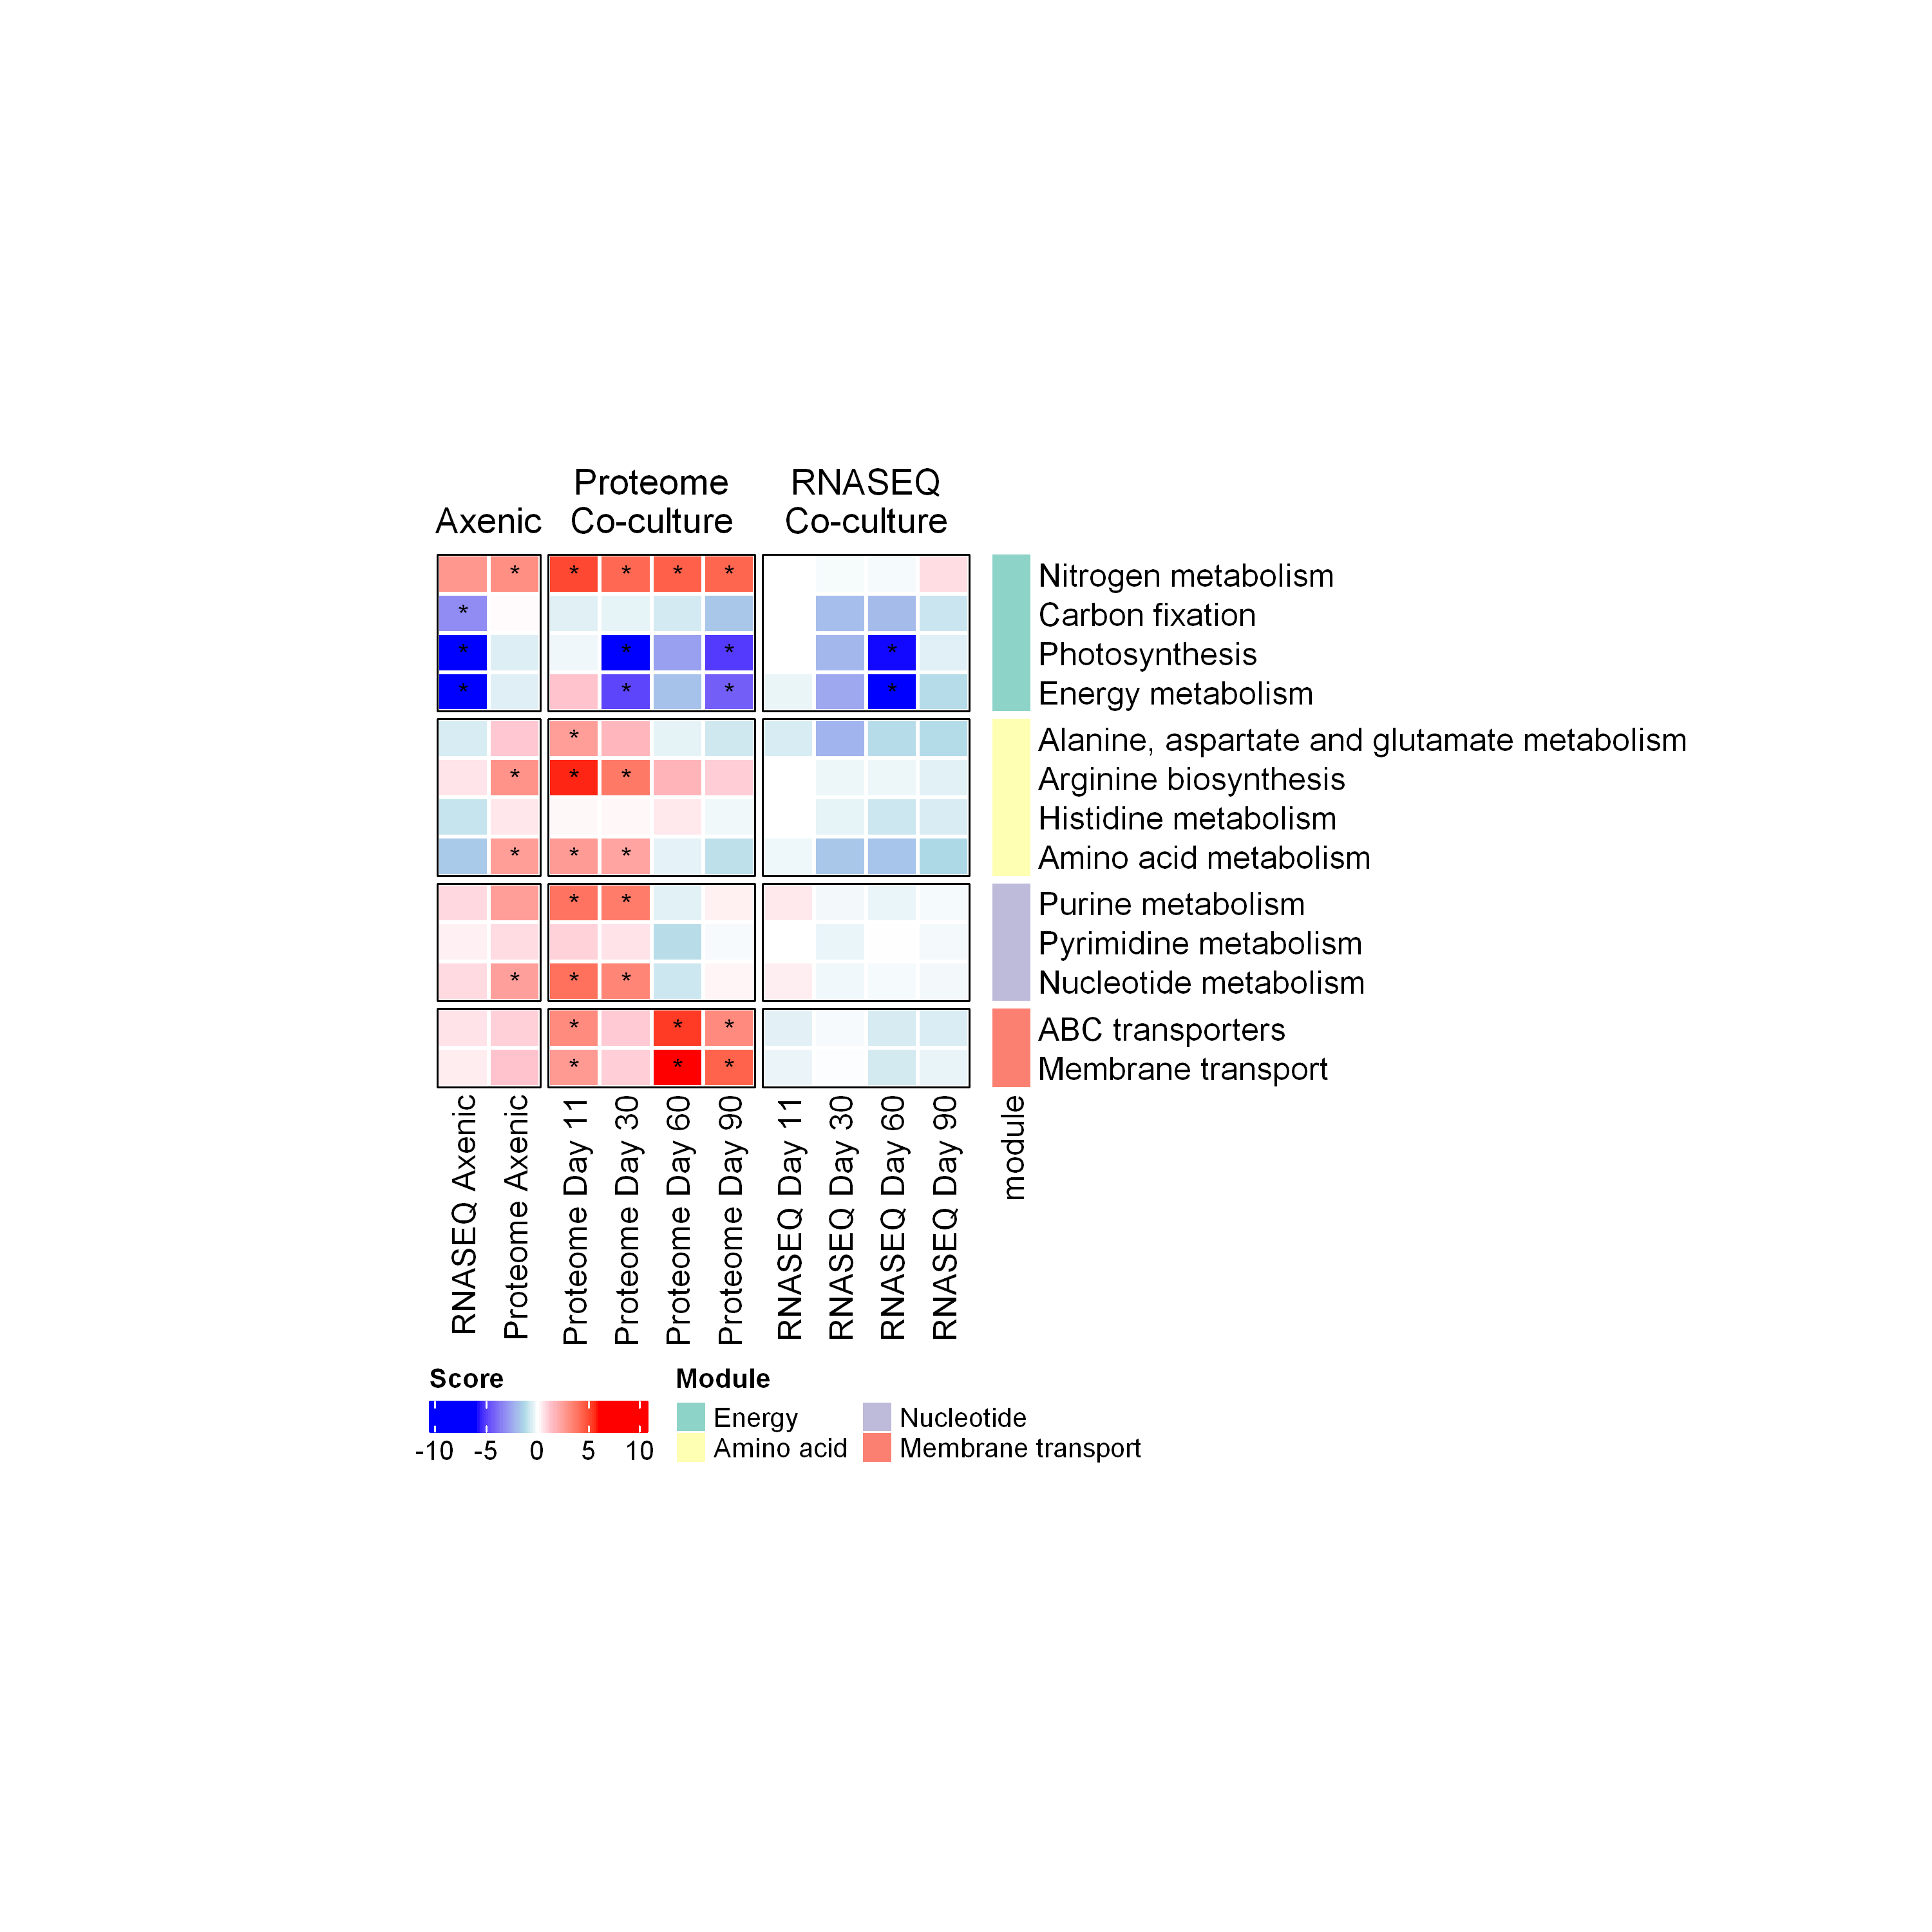

In [39]:
selected_modules = c(
    'Energy', 'Amino acid','Nucleotide',  'Membrane transport'
)

selected_pathways = c(
    "Nitrogen metabolism", "Carbon fixation", "Photosynthesis", "Energy metabolism",
    "Alanine, aspartate and glutamate metabolism", 
    "Arginine biosynthesis", "Histidine metabolism", "Amino acid metabolism",
    'Purine metabolism','Pyrimidine metabolism', 'Nucleotide metabolism',
    "ABC transporters", "Membrane transport")



toppaths = goseq_res %>% 
    filter(module %in% selected_modules,
           padj < 0.05) %>% 
    distinct(pathway)

contrast_list = c("P2vsP1_prot", "C2vsC1_prot", "C3vsC1_prot", 
                  "C4vsC1_prot", "C5vsC1_prot", 
                  "P2vsP1_rna", "C2vsC1_rna", "C3vsC1_rna", 
                  "C4vsC1_rna", "C5vsC1_rna")
 
days_list = c(
    C2vsC1_rna = 'RNASEQ Day 11', C3vsC1_rna='RNASEQ Day 30', 
    C4vsC1_rna = 'RNASEQ Day 60', C5vsC1_rna='RNASEQ Day 90',  
    P2vsP1_rna = 'RNASEQ Axenic',
    C2vsC1_prot = 'Proteome Day 11', C3vsC1_prot='Proteome Day 30', 
    C4vsC1_prot = 'Proteome Day 60', C5vsC1_prot='Proteome Day 90',  
    P2vsP1_prot = 'Proteome Axenic'
)

# row_ha = rowAnnotation(foo2 = runif(10), ))

module_mat = goseq_res %>% filter(pathway %in% toppaths$pathway) %>% 
    distinct(pathway, module) %>%
    mutate(module=factor(module, levels=selected_modules)) %>%
    mutate(pathway=factor(pathway, levels=selected_pathways)) %>%
    arrange(pathway) %>%
    column_to_rownames('pathway') 


# Heatmap(small_mat, name = "mat", col = col_fun, 
#     layer_fun = function(j, i, x, y, width, height, fill) {
#         v = pindex(small_mat, i, j)
#         l = v > 0
#         grid.text(sprintf("%.1f", v[l]), x[l], y[l], gp = gpar(fontsize = 10))
# })

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type %in% c('up', 'down')) %>% 
    filter(contrast %in% contrast_list) %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    group_by(pathway, contrast) %>%
    arrange(over_represented_pvalue) %>%
       filter(row_number()==1) %>%
    ungroup %>%
    mutate(day = days_list[contrast]) %>%
    pivot_wider(names_from = day, values_from = star, id_cols =pathway) %>% 
    mutate(pathway=factor(pathway, levels=selected_pathways)) %>%
    arrange(pathway) %>%
#    relocate(all_of(days_list)) %>%
    #relocate(11,30,60,90,'Axenic') %>%
    #relocate(all_of(days_list)) %>%
    relocate('RNASEQ Day 11', 'RNASEQ Day 30', 'RNASEQ Day 60', 'RNASEQ Day 90',  
             'Proteome Day 11', 'Proteome Day 30', 'Proteome Day 60', 'Proteome Day 90',  
             'RNASEQ Axenic','Proteome Axenic') %>%

    column_to_rownames('pathway') 

column_split_list = c(
    'RNASEQ\nCo-culture', 'RNASEQ\nCo-culture', 
    'RNASEQ\nCo-culture', 'RNASEQ\nCo-culture', 
    'Proteome\nCo-culture', 'Proteome\nCo-culture', 
    'Proteome\nCo-culture', 'Proteome\nCo-culture', 
                       'Axenic', 'Axenic')


up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type %in% c('up', 'down')) %>% 
    filter(contrast %in% contrast_list) %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    mutate(score = if_else(type == 'down', -score, score)) %>%
    mutate(day = days_list[contrast]) %>%
    group_by(pathway, contrast) %>%
    arrange(over_represented_pvalue) %>%
       filter(row_number()==1) %>%
    ungroup %>%
    pivot_wider(names_from = day, values_from = score, id_cols =pathway) %>% 
    mutate(pathway=factor(pathway, levels=selected_pathways)) %>%
    arrange(pathway) %>%
    relocate('RNASEQ Day 11', 'RNASEQ Day 30', 'RNASEQ Day 60', 'RNASEQ Day 90',  
             'Proteome Day 11', 'Proteome Day 30', 'Proteome Day 60', 'Proteome Day 90',  
             'RNASEQ Axenic','Proteome Axenic') %>%
    column_to_rownames('pathway') %>% as.matrix() %>%
Heatmap(
    name = 'Score',
    col=goseq_pal_updown_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    cluster_rows  = FALSE,    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    row_split = module_mat$module,
    column_split = column_split_list,
    #column_title_gp = gpar(col = group_pal),
    #column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(7, 'cm'),
    height=unit(7, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    
    #column_title = 'HOT1A3: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)


ann_mat = Heatmap(
    as.matrix(module_mat), 
    name='Module',
    width=unit(0.5, 'cm'),
    heatmap_legend_param = list(direction = "horizontal", ncol=3),
    col = structure(brewer.pal(length(unique(module_mat$module)), "Set3"), names = selected_modules),
    row_title=FALSE,
)

ht_list = up_mat + ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,)

No legend element is put in the last 1 column under `ncol = 3`, maybe
you should set `by_row = TRUE`? Reset `ncol` to 2.

No legend element is put in the last 1 column under `ncol = 3`, maybe
you should set `by_row = TRUE`? Reset `ncol` to 2.

No legend element is put in the last 1 column under `ncol = 3`, maybe
you should set `by_row = TRUE`? Reset `ncol` to 2.



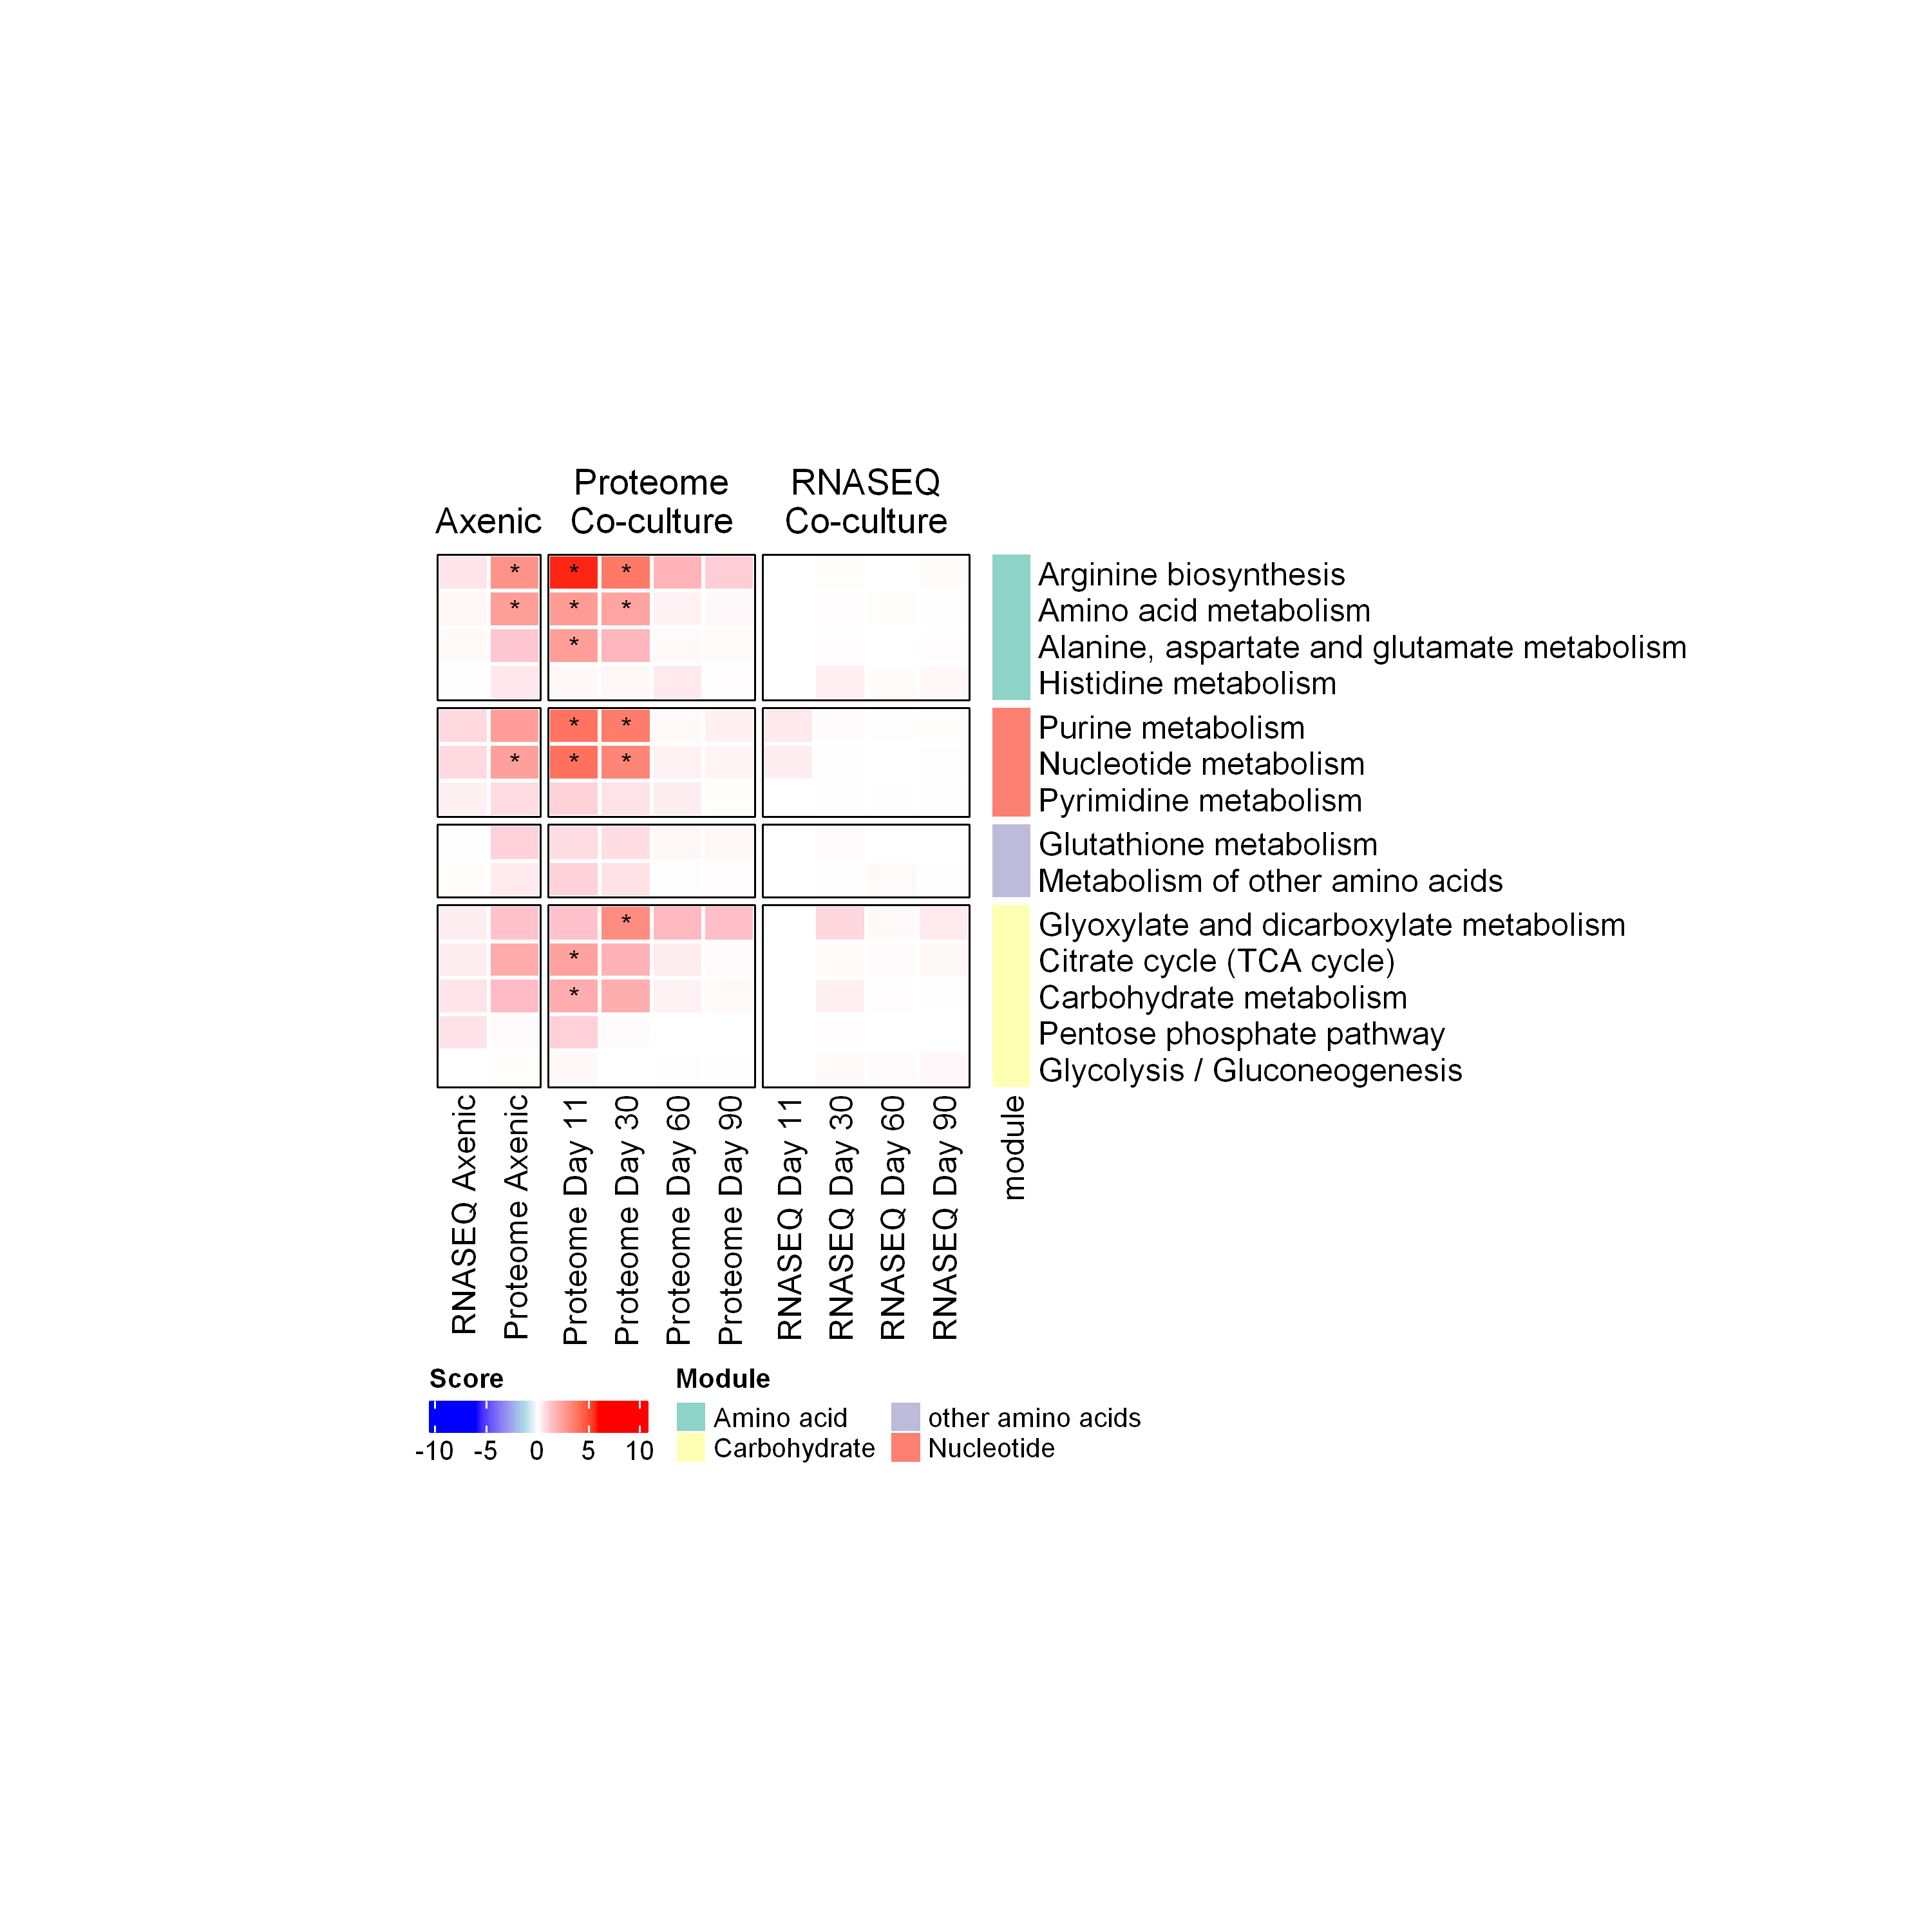

In [40]:
select_paths = c(
  "Amino acid metabolism", 
  "Arginine biosynthesis", 
  "Alanine, aspartate and glutamate metabolism", 
"Histidine metabolism", 
  "Glutathione metabolism", 
"Metabolism of other amino acids",
  "Nucleotide metabolism", 
  "Purine metabolism", 
  "Pyrimidine metabolism", 
  "Carbohydrate metabolism", 
"Citrate cycle (TCA cycle)", 
  "Glyoxylate and dicarboxylate metabolism", 
  "Glycolysis / Gluconeogenesis", 
"Pentose phosphate pathway"
)


toppaths = goseq_res %>% 
    filter(pathway %in% select_paths,
           padj < 0.05) %>% 
    distinct(pathway)

contrast_list = c("P2vsP1_prot", "C2vsC1_prot", "C3vsC1_prot", 
                  "C4vsC1_prot", "C5vsC1_prot", 
                  "P2vsP1_rna", "C2vsC1_rna", "C3vsC1_rna", 
                  "C4vsC1_rna", "C5vsC1_rna")
 
days_list = c(
    C2vsC1_rna = 'RNASEQ Day 11', C3vsC1_rna='RNASEQ Day 30', 
    C4vsC1_rna = 'RNASEQ Day 60', C5vsC1_rna='RNASEQ Day 90',  
    P2vsP1_rna = 'RNASEQ Axenic',
    C2vsC1_prot = 'Proteome Day 11', C3vsC1_prot='Proteome Day 30', 
    C4vsC1_prot = 'Proteome Day 60', C5vsC1_prot='Proteome Day 90',  
    P2vsP1_prot = 'Proteome Axenic'
)

# row_ha = rowAnnotation(foo2 = runif(10), ))

module_mat = goseq_res %>% filter(pathway %in% toppaths$pathway) %>% 
    distinct(pathway, module) %>%
    arrange(pathway) %>%
    column_to_rownames('pathway') 


# Heatmap(small_mat, name = "mat", col = col_fun, 
#     layer_fun = function(j, i, x, y, width, height, fill) {
#         v = pindex(small_mat, i, j)
#         l = v > 0
#         grid.text(sprintf("%.1f", v[l]), x[l], y[l], gp = gpar(fontsize = 10))
# })

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type %in% c('up')) %>% 
    filter(contrast %in% contrast_list) %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    group_by(pathway, contrast) %>%
    arrange(over_represented_pvalue) %>%
       filter(row_number()==1) %>%
    ungroup %>%
    mutate(day = days_list[contrast]) %>%
    pivot_wider(names_from = day, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
#    relocate(all_of(days_list)) %>%
    #relocate(11,30,60,90,'Axenic') %>%
    #relocate(all_of(days_list)) %>%
    relocate('RNASEQ Day 11', 'RNASEQ Day 30', 'RNASEQ Day 60', 'RNASEQ Day 90',  
             'Proteome Day 11', 'Proteome Day 30', 'Proteome Day 60', 'Proteome Day 90',  
             'RNASEQ Axenic','Proteome Axenic') %>%

    column_to_rownames('pathway') 

column_split_list = c(
    'RNASEQ\nCo-culture', 'RNASEQ\nCo-culture', 
    'RNASEQ\nCo-culture', 'RNASEQ\nCo-culture', 
    'Proteome\nCo-culture', 'Proteome\nCo-culture', 
    'Proteome\nCo-culture', 'Proteome\nCo-culture', 
                       'Axenic', 'Axenic')


up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type %in% c('up')) %>% 
    filter(contrast %in% contrast_list) %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    mutate(score = if_else(type == 'down', -score, score)) %>%
    mutate(day = days_list[contrast]) %>%
    group_by(pathway, contrast) %>%
    arrange(over_represented_pvalue) %>%
       filter(row_number()==1) %>%
    ungroup %>%
    pivot_wider(names_from = day, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate('RNASEQ Day 11', 'RNASEQ Day 30', 'RNASEQ Day 60', 'RNASEQ Day 90',  
             'Proteome Day 11', 'Proteome Day 30', 'Proteome Day 60', 'Proteome Day 90',  
             'RNASEQ Axenic','Proteome Axenic') %>%
    column_to_rownames('pathway') %>% as.matrix() %>%
Heatmap(
    name = 'Score',
    col=goseq_pal_updown_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_columns  = FALSE,
    show_row_dend = FALSE,
    #column_order = rownames(goseq_meta),
    row_split = module_mat$module,
    column_split = column_split_list,
    #column_title_gp = gpar(col = group_pal),
    #column_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(7, 'cm'),
    height=unit(7, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 10))
    },
    
    #column_title = 'HOT1A3: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)


ann_mat = Heatmap(
    as.matrix(module_mat), 
    name='Module',
    width=unit(0.5, 'cm'),
    heatmap_legend_param = list(direction = "horizontal", ncol=3),
    col = structure(brewer.pal(length(unique(module_mat$module)), "Set3"), names = unique(module_mat$module)),
    row_title=FALSE,
)

ht_list = up_mat + ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,)

In [41]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

# Heatmap per Module

In [42]:
genome = 'HOT1A3'

In [43]:
modules_de = goseq_res %>% 
    filter(padj < 0.05) %>% 
    count(module)



In [44]:
deg = df_all %>% filter(padj < 0.05) %>% distinct(gene_id)
hpath_df %>% 
    filter(gene_id %in% deg$gene_id, module %in% modules_de$module) %>% 
    distinct(gene_id, module) %>%
    count(module) %>% arrange(n)



module,n
<chr>,<int>
Lipid,25
other secondary metabolites,25
terpenoids and polyketides,25
other amino acids,30
Membrane transport,42
Nucleotide,55
Translation,78
Carbohydrate,88
Amino acid,108


## cofactors and vitamins 

In [45]:
module_name = 'cofactors and vitamins'
module_title = paste0(genome, ' ',module_name)

In [46]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [47]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


In [48]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [49]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)

gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>%
#    select(pathwaylist$pathway) %>% 
as.matrix()
head(gene_meta)

,gene,Thiamine metabolism,Porphyrin metabolism,Vitamin B6 metabolism,Pantothenate and CoA biosynthesis,Ubiquinone and other terpenoid-quinone biosynthesis,Nicotinate and nicotinamide metabolism,Folate biosynthesis,One carbon pool by folate,Biotin metabolism,Riboflavin metabolism,Lipoic acid metabolism,Retinol metabolism
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TX50_RS00110,rsgA,Yes,No,No,No,No,No,No,No,No,No,No,No
TX50_RS00195,cbiD,No,Yes,No,No,No,No,No,No,No,No,No,No
TX50_RS00275,(E1.1.1.65),No,No,Yes,No,No,No,No,No,No,No,No,No
TX50_RS00415,"(LYS5, acpT)",No,No,No,Yes,No,No,No,No,No,No,No,No
TX50_RS00425,(coaX),No,No,No,Yes,No,No,No,No,No,No,No,No
TX50_RS00435,"(NDC1, ndbB)",No,No,No,No,Yes,No,No,No,No,No,No,No


In [50]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


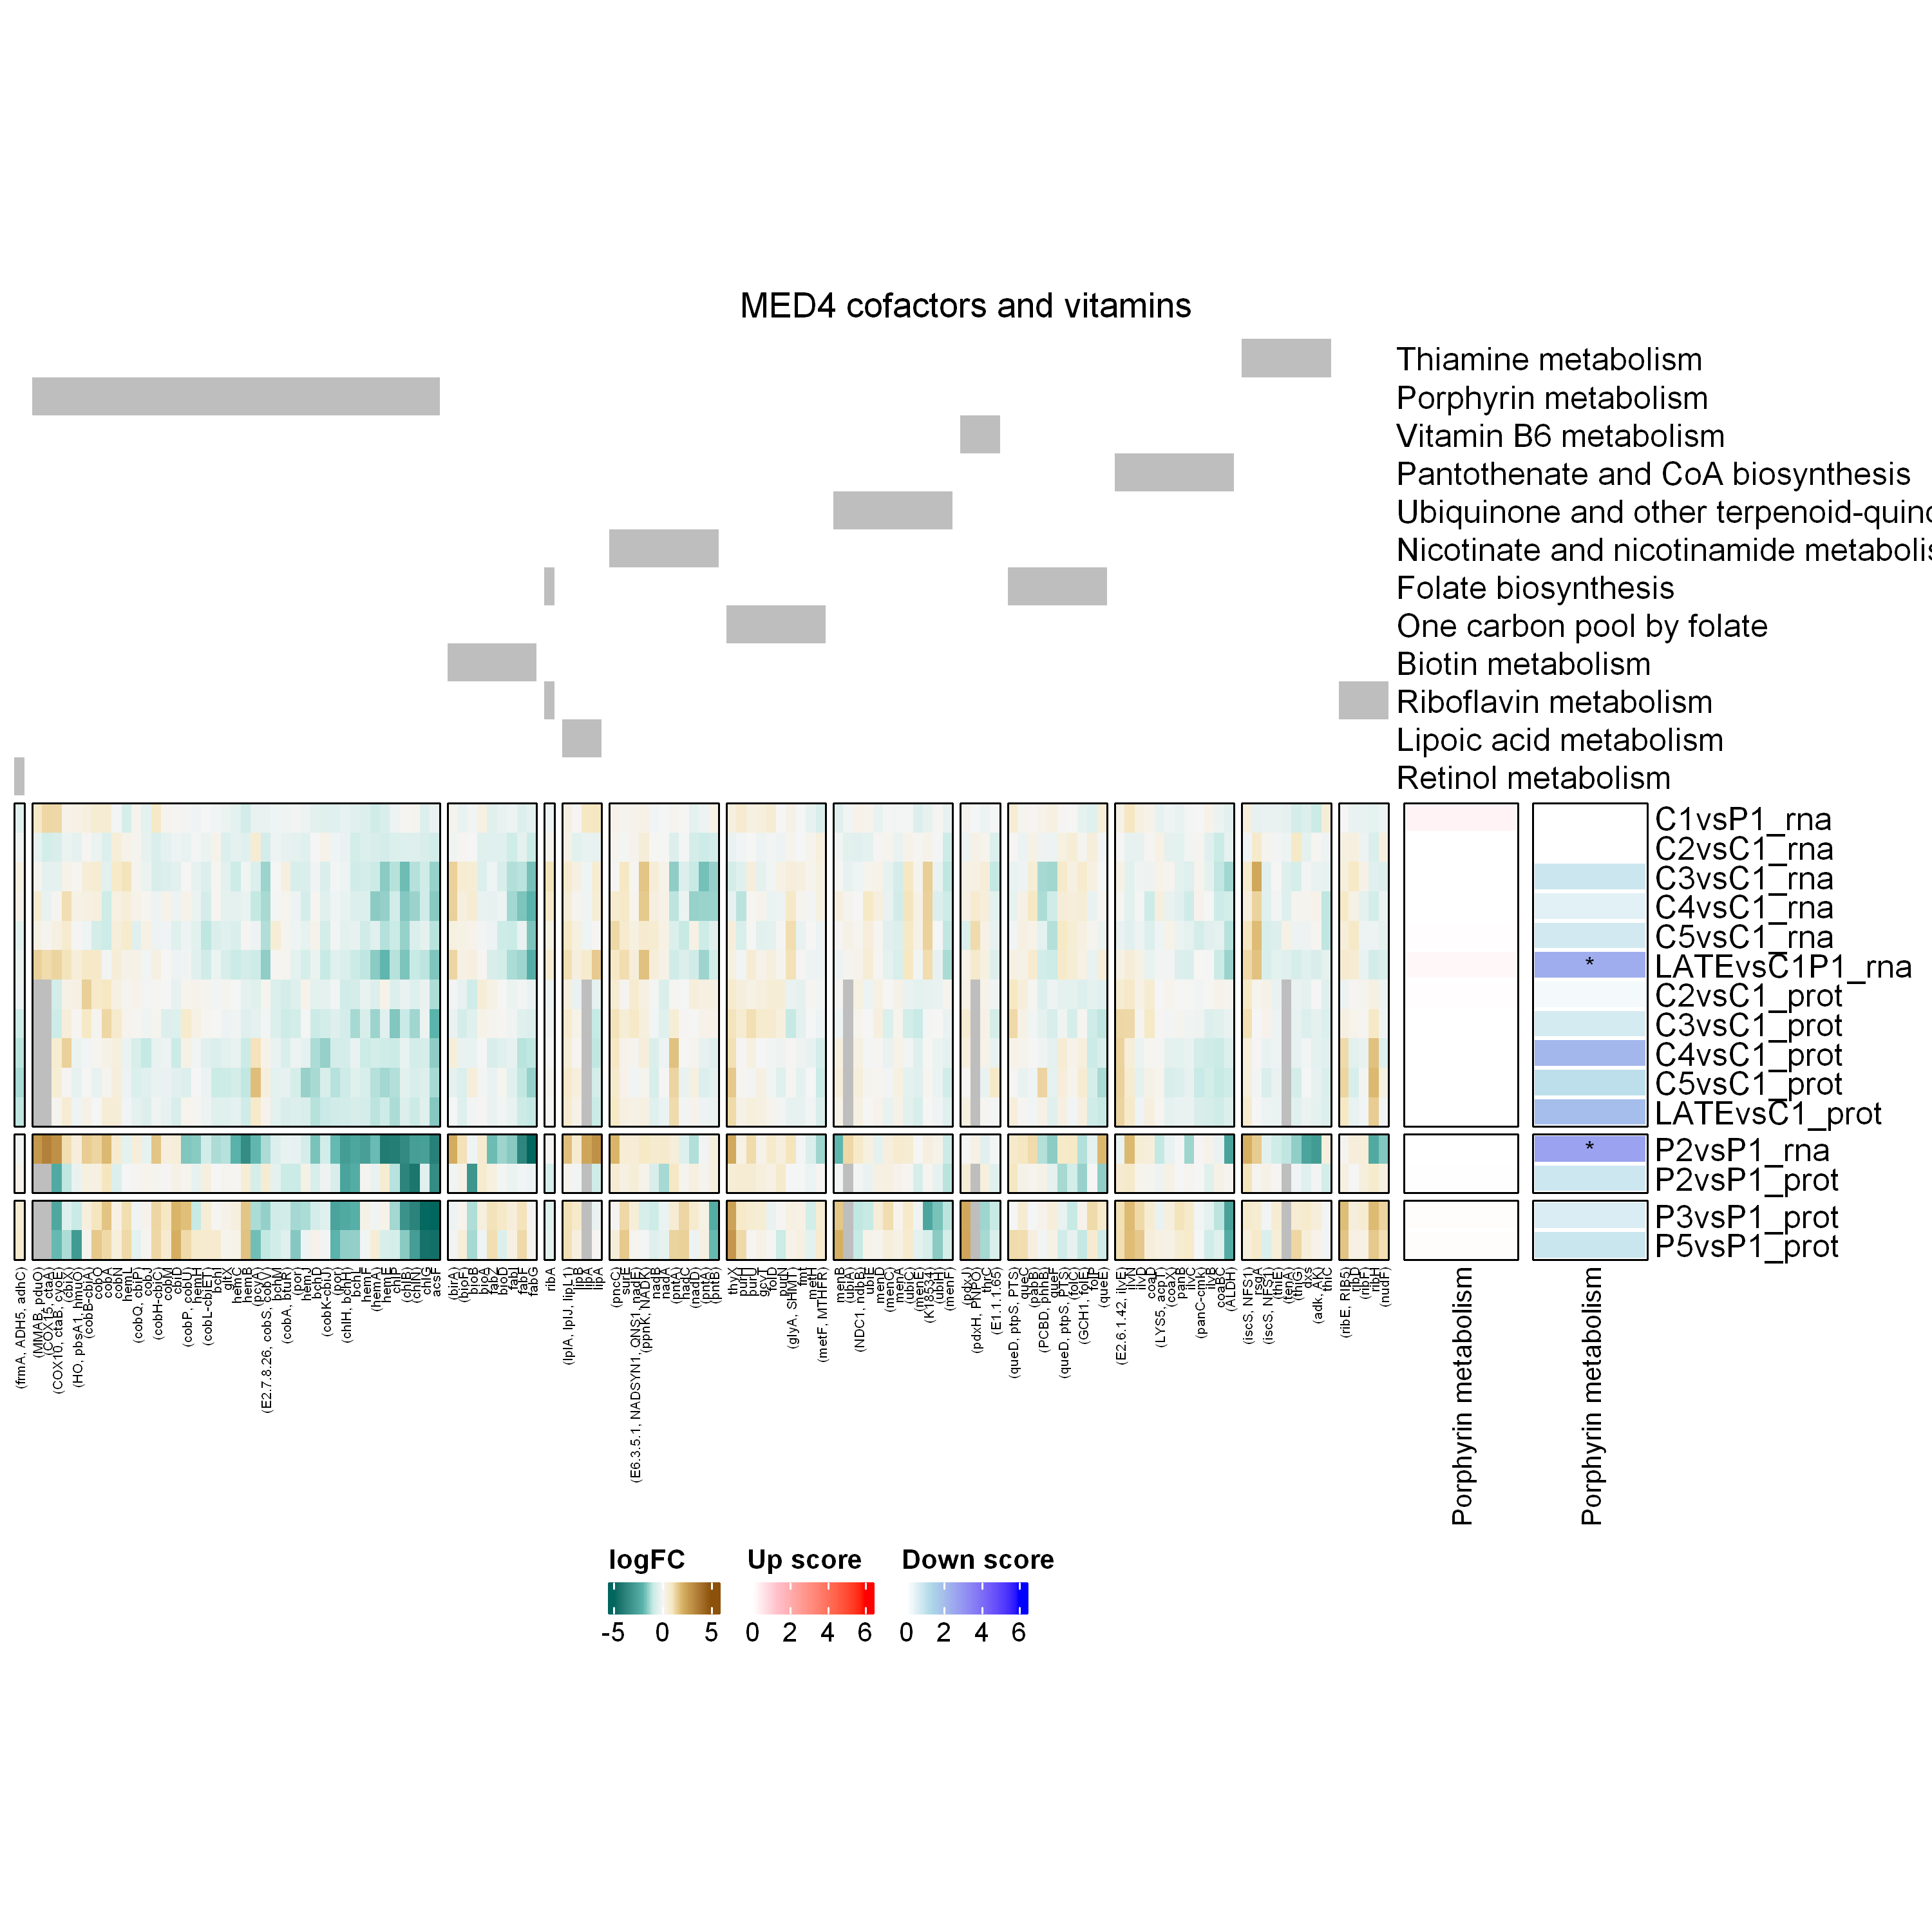

In [51]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
     column_names_gp = gpar(fontsize = 10),    
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'HOT1A3: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
     column_names_gp = gpar(fontsize = 10),    
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 5),    
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
#     cell_fun = function(j, i, x, y, width, height, fill) {
#         grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
#     },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Energy + photosynthesis

In [ ]:
module_name = 'Energy'
module_title = paste0(genome, ' ',module_name)

In [ ]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           str_detect(pathway, 'Photosynthesis'), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [ ]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


In [ ]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [ ]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)

gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>%
    #    select(pathwaylist$pathway) %>% 
    as.matrix()
head(gene_meta)

In [ ]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


In [ ]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
     column_names_gp = gpar(fontsize = 10),    
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
     column_names_gp = gpar(fontsize = 10),    
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 9),    
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Energy - photosynthesis

In [ ]:
module_name = 'Energy'
module_title = paste0(genome, ' ',module_name)

In [ ]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           !str_detect(pathway, 'Photosynthesis'), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [ ]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


In [ ]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [ ]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)

gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>%
    #    select(pathwaylist$pathway) %>% 
    as.matrix()
head(gene_meta)

In [ ]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


In [ ]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05
          ) %>% 
    distinct(pathway)
#toppaths = pathwaylist

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
     column_names_gp = gpar(fontsize = 10),    
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
     column_names_gp = gpar(fontsize = 10),    
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 9),    
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

In [ ]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
#           !str_detect(pathway, 'Photosynthesis'), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [ ]:
cbb_genes = hpath_df %>% filter(str_detect(gene, 'cbb'))
cbb_genes

In [ ]:
bpath_df %>% filter(gene_id %in% cbb_genes$gene_id) #%>% count(Pathways.of.gene, Ontology...pathway.type)

In [ ]:
bpath_df %>% 
    filter(# !main %in% ignore_main, 
           gene_id %in% degenes$gene_id) %>% 
#    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, Ontology...pathway.type) %>%
    count(Ontology...pathway.type) %>% arrange(desc(n))


In [ ]:
bpath_df %>% 
    filter(# !main %in% ignore_main, 
           gene_id %in% degenes$gene_id) %>% 
#    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, Pathways.of.gene) %>%
    count(Pathways.of.gene) %>% arrange(desc(n))


## Carbohydrate 

In [ ]:
module_name = 'Carbohydrate'
module_title = paste0(genome, ' ',module_name)

In [ ]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [ ]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


In [ ]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [ ]:
toppaths

In [ ]:
hpath_df %>% 
    filter(gene_id %in% degenes$gene_id) %>%
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, pathway, .keep_all = TRUE) %>%
   count(pathway) %>% arrange(desc(n))   
   # count(module) %>% arrange(desc(n))

In [ ]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)

gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>%
    select(pathwaylist$pathway) %>% 
    #select(toppaths$pathway) %>% 
as.matrix()
head(gene_meta)

In [ ]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


In [ ]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
     column_names_gp = gpar(fontsize = 10),    
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
     column_names_gp = gpar(fontsize = 10),    
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 7),    
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Translation 

In [ ]:
module_name = 'Translation'
module_title = paste0(genome, ' ',module_name)

In [ ]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [ ]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [ ]:
gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>% as.matrix()
head(gene_meta)

In [ ]:
hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
#    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    count(pathway) %>% arrange(desc(n))


In [ ]:
bpath_df %>% 
    filter(# !main %in% ignore_main, 
           gene_id %in% degenes$gene_id) %>% 
#    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, Ontology...pathway.type) %>%
    count(Ontology...pathway.type) %>% arrange(desc(n))


In [ ]:
bpath_df %>% 
    filter(# !main %in% ignore_main, 
           gene_id %in% degenes$gene_id) %>% 
#    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, Pathways.of.gene) %>%
    count(Pathways.of.gene) %>% arrange(desc(n))


In [ ]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


In [ ]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 7),    
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Nucleotide 

In [ ]:
module_name = 'Nucleotide'
module_title = paste0(genome, ' ',module_name)

In [ ]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           #str_detect(gene, 'pur'), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [ ]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [ ]:
toppaths = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    #filter(str_detect(sub, module_name)) %>%
    filter(pathway != 'Drug metabolism - other enzymes') %>%
    distinct(gene_id, gene, pathway) %>%
    count(pathway) %>% filter(n>=4)
toppaths

In [ ]:
degradation_genes = bpath_df %>% 
    filter(gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(Pathways.of.gene, 'salvage|degradation')) %>%
    distinct(gene_id) 

In [ ]:
gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    #filter(pathway %in% toppaths$pathway) %>%
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    mutate(biocyc_degaradation = if_else(gene_id %in% degradation_genes$gene_id, 'Yes', 'No')) %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>% as.matrix()
head(gene_meta)

In [ ]:
hpath_df %>% 
    filter(# !main %in% ignore_main, 
           gene_id %in% degenes$gene_id) %>% 
#    filter(str_detect(sub, module_name)) %>%
    count(pathway) %>% arrange(desc(n))


In [ ]:
ppgpp_genes = bpath_df %>% filter(Pathways.of.gene == 'ppGpp metabolism' )
ppgpp_genes

In [ ]:
bpath_df %>% 
    filter(# !main %in% ignore_main, 
           gene_id %in% degenes$gene_id) %>% 
#    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, Ontology...pathway.type) %>%
    count(Ontology...pathway.type) %>% arrange(desc(n))


In [ ]:
bpath_df %>% 
    filter(# !main %in% ignore_main, 
           gene_id %in% degenes$gene_id) %>% 
#    filter(str_detect(sub, module_name)) %>%
    filter(str_detect(Pathways.of.gene, 'salvage|degradation')) %>%
    distinct(gene_id, Pathways.of.gene) #%>%
    #count(Pathways.of.gene) %>% arrange(desc(n)) #%>%
    #filter(str_detect(Pathways.of.gene, 'salvage|degradation'))
    #count(gene_id, Pathways.of.gene)

In [ ]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


In [ ]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     border=TRUE,
     #width=unit(5, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## other amino acids 

In [ ]:
module_name = 'other amino acids'
module_title = paste0(genome, ' ',module_name)

In [ ]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [ ]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [ ]:
gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>% as.matrix()
head(gene_meta)

In [ ]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


In [ ]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## terpenoids and polyketides

In [ ]:
module_name = 'terpenoids and polyketides'
module_title = paste0(genome, ' ',module_name)

In [ ]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [ ]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [ ]:
gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>% as.matrix()
head(gene_meta)

In [ ]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


In [ ]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## other secondary metabolites

In [ ]:
module_name = 'other secondary metabolites'
module_title = paste0(genome, ' ',module_name)

In [ ]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [ ]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [ ]:
gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(str_detect(sub, module_name)) %>%
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>% as.matrix()
head(gene_meta)

In [ ]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


In [ ]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Transporters

In [52]:
module_name = 'Membrane transport'
module_title = paste0(genome, ' ',module_name)

In [53]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [54]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [55]:
hpath_df %>% filter(module == 'Membrane transport') %>%
    extract(ecpath, c("system"), "^K[[:digit:]]+ *[^;]*; (.* system)", remove = FALSE) %>%
    mutate(system = if_else(str_detect(ecpath, 'preprotein translocase'), 'preprotein translocase', system)) %>%
    mutate(system = if_else(str_detect(ecpath, 'sec-independent protein translocase'), 'sec-independent protein translocase', system)) %>%
    count(system)
    #filter(is.na(system)) %>% distinct(ecpath)

system,n
<chr>,<int>
biotin transport system,1
energy-coupling factor transport system,3
iron(III) transport system,3
lipopolysaccharide export system,2
manganese transport system,3
nitrate/nitrite transport system,3
phosphate transport system,4
phospholipid/cholesterol/gamma-HCH transport system,3
phosphonate transport system,4


In [56]:
gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    filter(module == 'Membrane transport') %>%
    extract(ecpath, c("system"), "^K[[:digit:]]+ *[^;]*; (.* system)", remove = FALSE) %>%
    mutate(system = if_else(str_detect(ecpath, 'preprotein translocase'), 'preprotein translocase', system)) %>%
    mutate(system = if_else(str_detect(ecpath, 'sec-independent protein translocase'), 'sec-independent protein translocase', system)) %>%
    mutate(system = str_replace(system, " translocase", "")) %>%
    mutate(system = str_replace(system, " transport system", "")) %>%
    mutate(system = str_replace(system, " system", "")) %>%
    mutate(system = if_else(is.na(system), '', system)) %>%

    distinct(gene_id, gene, system) %>%
    #mutate(value_col = 'Yes') %>%
    #pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'system', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
#gene_meta_matrix = gene_meta %>% select(!gene) %>% as.matrix()
head(gene_meta)

,gene,system
,<chr>,<chr>
TX50_RS00065,ftsY,
TX50_RS00345,"(bacA, bclA)",vitamin B12/bleomycin/antimicrobial peptide
TX50_RS00655,(ecfA1),energy-coupling factor
TX50_RS01065,secE,preprotein
TX50_RS01500,"(mlaD, linM)",phospholipid/cholesterol/gamma-HCH
TX50_RS01505,"(mlaF, linL, mkl)",phospholipid/cholesterol/gamma-HCH


In [57]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


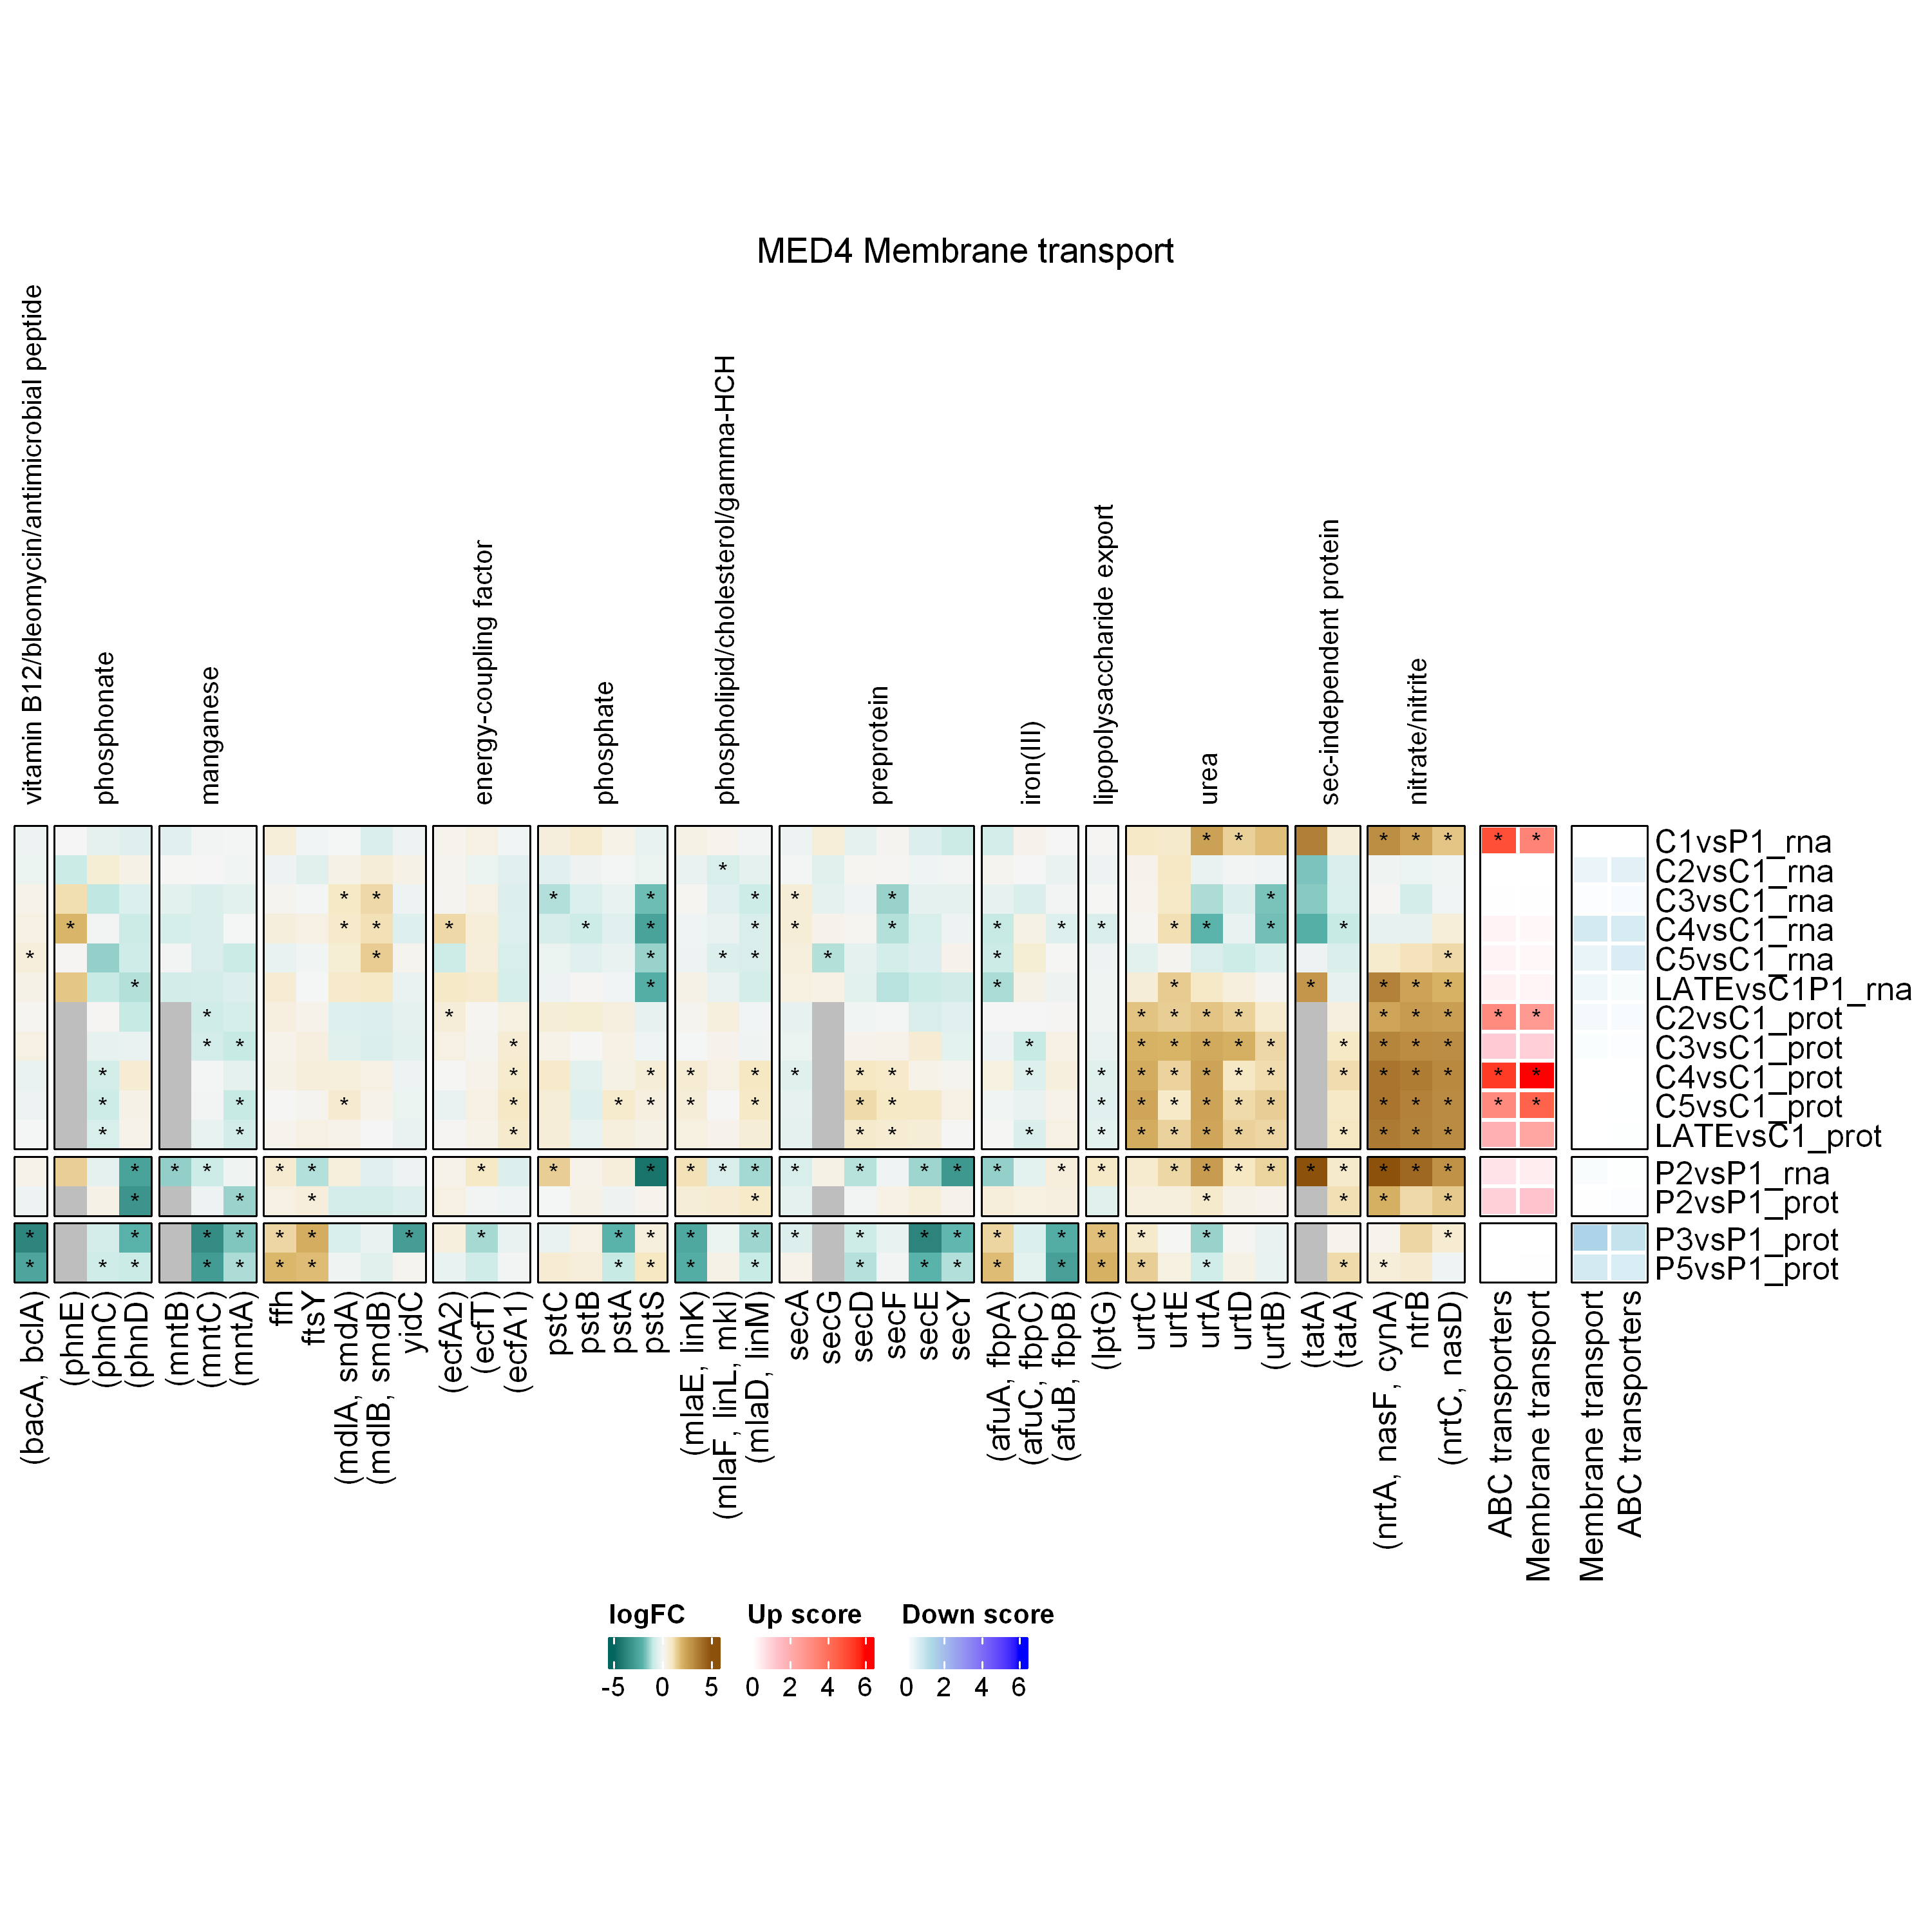

In [58]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     #column_title=NULL,
    column_split = gene_meta$system,
    column_title_gp = gpar(fontsize = 10),    
    column_title_rot = 90,
    column_labels=gene_meta$gene,
#     top_annotation = HeatmapAnnotation(
#         Pathway=gene_meta$system, 
#         #show_legend =FALSE,
#         #col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
#         #show_legend=FALSE,
#     ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

In [109]:
paste0(unique(gene_meta$system), collapse = ' , ')

[1] " , vitamin B12/bleomycin/antimicrobial peptide , energy-coupling factor , preprotein , phospholipid/cholesterol/gamma-HCH , sec-independent protein , nitrate/nitrite , iron(III) , manganese , phosphonate , phosphate , urea , lipopolysaccharide export"

## Lipid

In [110]:
module_name = 'Lipid'
module_title = paste0(genome, ' ',module_name)

In [111]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [112]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [113]:
gene_meta = hpath_df %>% 
    filter(str_detect(sub, module_name)) %>%
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% select(!gene) %>% as.matrix()
head(gene_meta)

,gene,Fatty acid biosynthesis,Glycerolipid metabolism,Glycerophospholipid metabolism,Fatty acid degradation,Arachidonic acid metabolism
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TX50_RS00150,accB,Yes,No,No,No,No
TX50_RS00320,accC,Yes,No,No,No,No
TX50_RS00710,plsX,No,Yes,No,No,No
TX50_RS00715,(fabH),Yes,No,No,No,No
TX50_RS00720,fabD,Yes,No,No,No,No
TX50_RS00725,(plsC),No,Yes,Yes,No,No


In [114]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


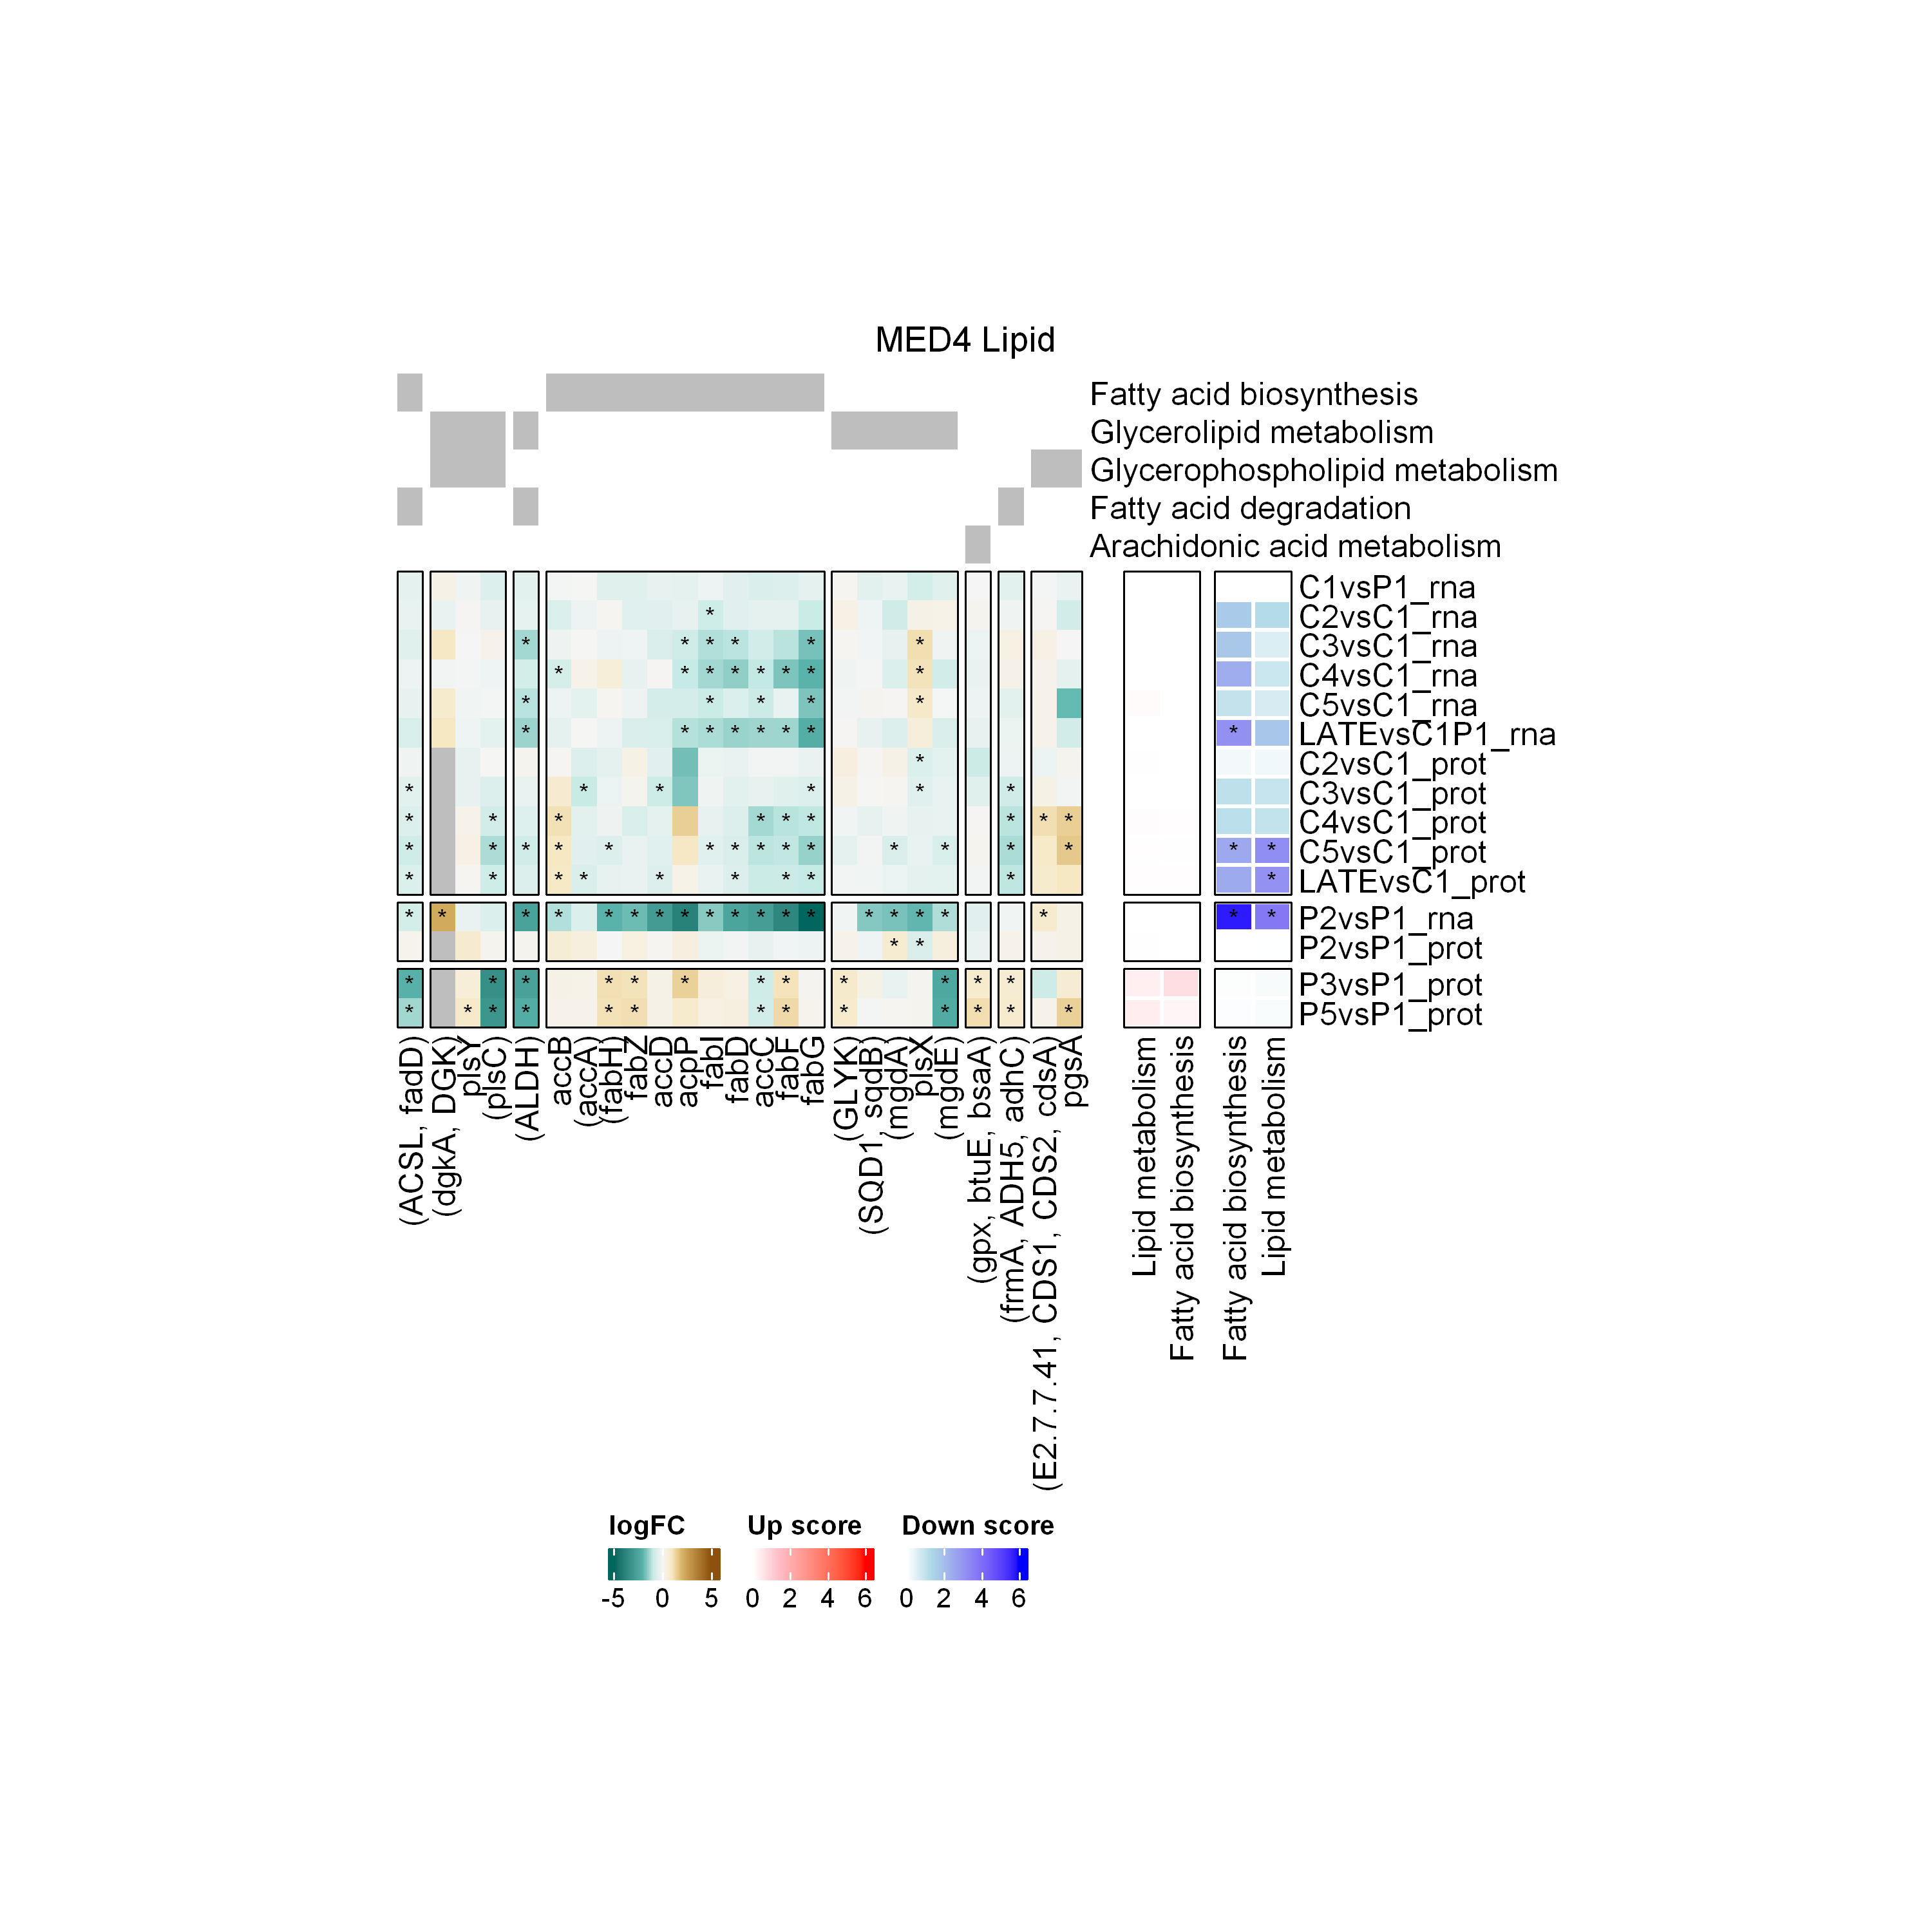

In [115]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)


up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=goseq_pal_up_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=goseq_pal_down_fun,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = goseq_pal_fc_fun,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     border=TRUE,
     width=unit(9, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
ht_list = gene_mat + up_mat + down_mat #+ ann_mat
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

## Amino acid

In [116]:
module_name = 'Amino acid'
module_title = paste0(genome, ' ',module_name)

In [117]:
toppaths = goseq_res %>% 
    filter(module %in% module_name, 
           padj < 0.05) %>% 
    distinct(pathway)

In [118]:
degenes = df_all %>% 
    filter(str_detect(sub, module_name), 
           padj < 0.05) %>% 
    distinct(gene_id)

In [119]:
ignore_main = c('09160 Human Diseases', 
                '09150 Organismal Systems', 
                '09190 Not Included in Pathway or Brite', 
                '09180 Brite Hierarchies',
                ''
               )

In [120]:
gene_stars

,TX50_RS00150,TX50_RS00320,TX50_RS00710,TX50_RS00715,TX50_RS00720,TX50_RS00725,TX50_RS00950,TX50_RS01465,TX50_RS01745,TX50_RS02160,⋯,TX50_RS05105,TX50_RS05380,TX50_RS05825,TX50_RS06645,TX50_RS07125,TX50_RS07170,TX50_RS08605,TX50_RS08610,TX50_RS08865,TX50_RS08895
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
C1vsP1_rna,,,,,,,,,,,⋯,,,,,,,,,,
C2vsC1_rna,,,,,,,,*,,,⋯,,,,,,,,,,
C3vsC1_rna,,,*,,*,,,*,*,,⋯,,,,,,,*,,,
C4vsC1_rna,*,*,*,,*,,,*,,,⋯,,,,,,,*,*,,
C5vsC1_rna,,*,*,,,,,*,*,,⋯,,,,,,,,,,
LATEvsC1P1_rna,,*,,,*,,,*,*,,⋯,,,,,,,*,*,,
C2vsC1_prot,,,*,,,,,,,,⋯,,,,,,,,,,
C3vsC1_prot,,,*,,,,,,,*,⋯,,,,*,,,,,,
C4vsC1_prot,*,*,,,,*,,,,*,⋯,,,*,*,,,,*,,


In [121]:
pathwaylist

pathway
<chr>
Amino sugar and nucleotide sugar metabolism
Glycolysis / Gluconeogenesis
Pentose phosphate pathway
Citrate cycle (TCA cycle)
Glyoxylate and dicarboxylate metabolism


In [122]:
pathwaylist = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    add_count(pathway) %>%
    filter((n >= 20) | (pathway %in% toppaths$pathway)) %>% distinct(pathway)


gene_meta = hpath_df %>% 
    filter(!main %in% ignore_main, gene_id %in% degenes$gene_id) %>% 
    distinct(gene_id, gene, pathway) %>%
    mutate(value_col = 'Yes') %>%
    pivot_wider(id_cols=c('gene_id', 'gene'), names_from = 'pathway', values_from = 'value_col', values_fill = 'No') %>%
    column_to_rownames('gene_id')
gene_meta_matrix = gene_meta %>% 
    select(pathwaylist$pathway) %>%
    as.matrix()
#head(gene_meta)
#gene_meta_matrix

In [123]:
gene_stars = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(id_cols = contrast1, values_from = star, names_from = gene_id, values_fill = '') %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) 


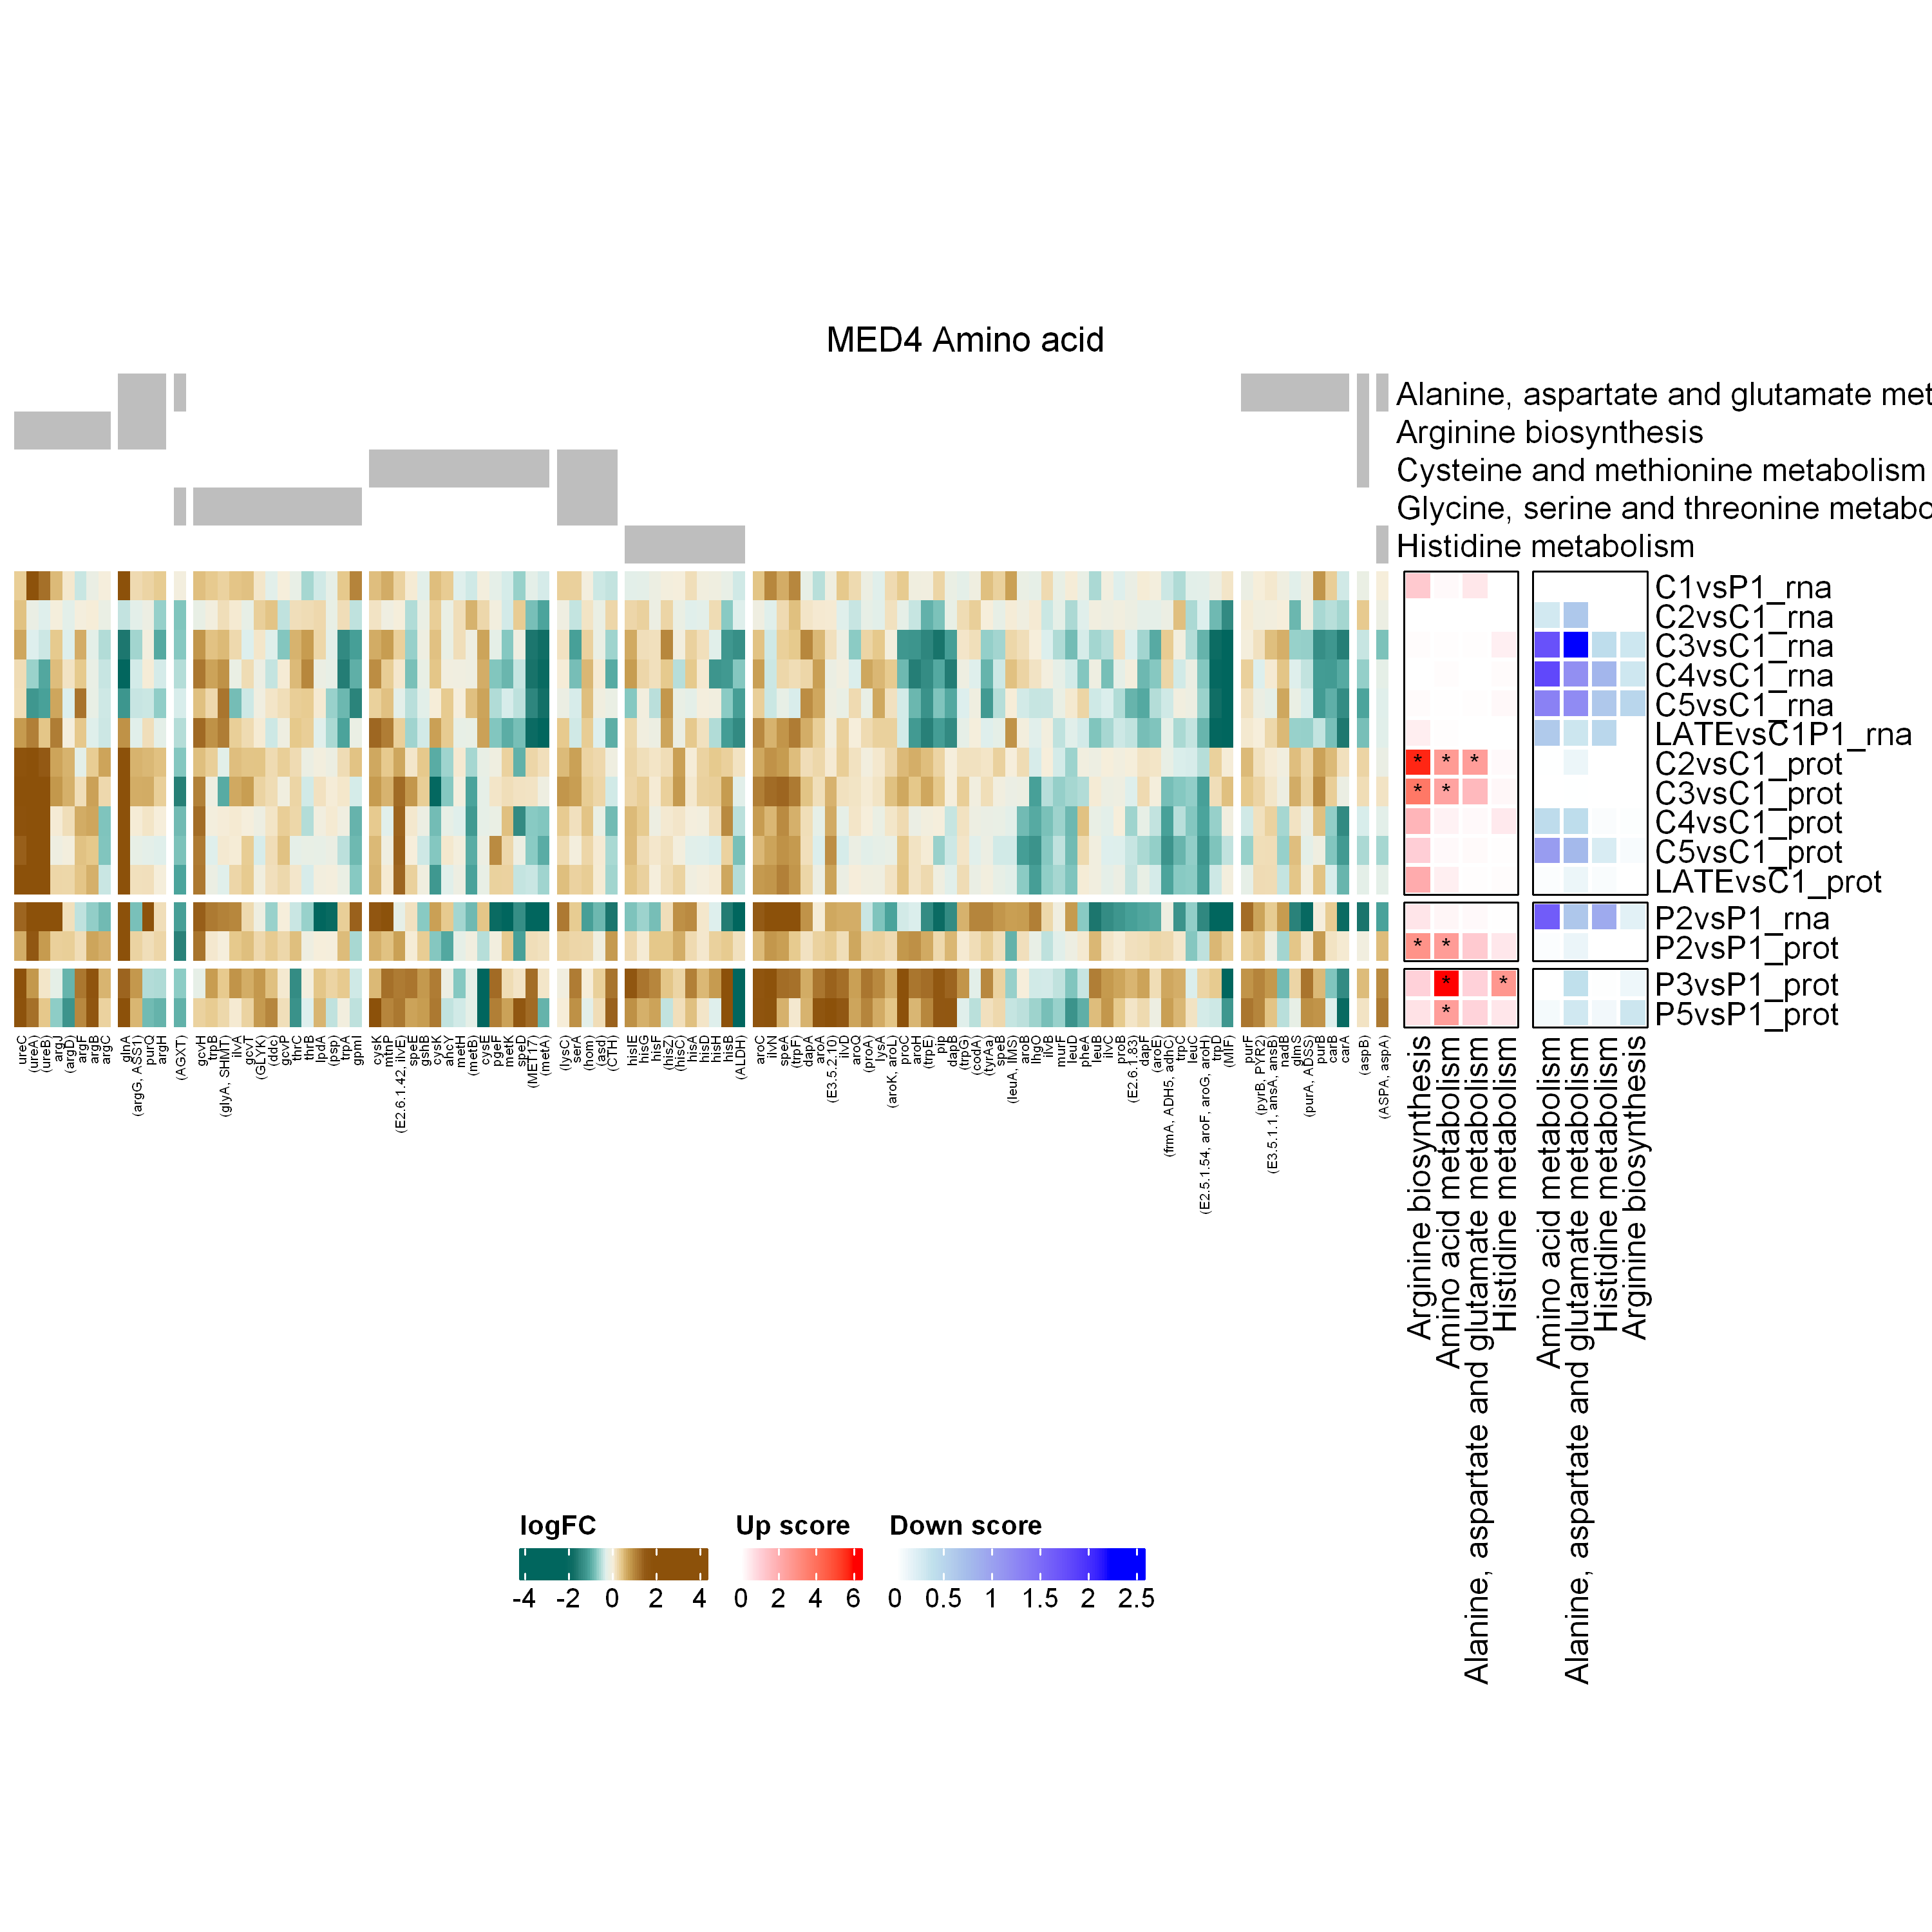

In [124]:

up_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()
down_stars = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    replace_na(list(padj=1)) %>%
    mutate(star = if_else(padj < 0.05, '*', '')) %>%
    pivot_wider(names_from = contrast, values_from = star, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t()

up_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='up') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Up score',
    col=pupgoseq,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", up_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
    
    #column_title = 'MED4: GOSEQ Score - upregulated',
) #, annotation_col = goseq_meta) #, annotation_row = path_meta)
down_mat = goseq_res %>% filter(pathway %in% toppaths$pathway, type=='down') %>% 
    mutate(score = -log10(over_represented_pvalue)) %>%
    mutate(score = if_else(score > 6, 6, score)) %>%
    pivot_wider(names_from = contrast, values_from = score, id_cols =pathway) %>% 
    arrange(pathway) %>%
    relocate(rownames(goseq_meta)) %>%
    column_to_rownames('pathway') %>% t() %>%
Heatmap(
    name = 'Down score',
    col=pdowngoseq,
    rect_gp = gpar(col = "white", lwd = 2),
    cluster_rows  = FALSE,
    show_column_dend = FALSE,
    row_order = rownames(goseq_meta),
    row_split = goseq_meta$Group,
    
    #row_title_gp = gpar(col = group_pal),
    #row_names_gp = gpar(col = group_pal),
    border=TRUE,
    width=unit(1.5, 'cm'),
    height=unit(6, 'cm'),
    heatmap_legend_param = list(direction = "horizontal"),
    row_title=NULL,
    cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf("%s", down_stars[i, j]), x, y, gp = gpar(fontsize = 9))
    },
) 

gene_mat = df_all %>% filter(gene_id %in% degenes$gene_id) %>% 
    pivot_wider(id_cols = contrast1, values_from = logFC, names_from = gene_id) %>% 
    mutate(contrast1 = factor(contrast1, levels=rownames(goseq_meta))) %>%
    arrange(contrast1) %>%
    column_to_rownames('contrast1')  %>%
    relocate(rownames(gene_meta)) %>% as.matrix() %>%
Heatmap(
     name = 'logFC',
    col = pfcgoseq,
#     rect_gp = gpar(col = "white", lwd = 2),
     cluster_rows  = FALSE,
     show_column_dend = FALSE,
     row_order = rownames(goseq_meta),
     row_split = goseq_meta$Group,
    
#     #row_title_gp = gpar(col = group_pal),
     row_names_gp = gpar(col = group_pal),
     column_names_gp = gpar(fontsize = 5),
     #border=TRUE,
#     width=unit(1, 'cm'),
     height=unit(6, 'cm'),
     heatmap_legend_param = list(direction = "horizontal"),
     row_title=NULL,
     column_title=NULL,
    column_split = gene_meta_matrix,
    column_labels=gene_meta$gene,
    top_annotation = HeatmapAnnotation(
        Pathway=gene_meta_matrix, 
        show_legend =FALSE,
        col = list(Pathway = c('Yes' = "grey", 'No' = "white"))#,
        #show_legend=FALSE,
    ),
    
#     cell_fun = function(j, i, x, y, width, height, fill) {
#         grid.text(sprintf("%s", gene_stars[i, j]), x, y, gp = gpar(fontsize = 9))
#     },
    
) 
ht_list = gene_mat + up_mat + down_mat 
draw(ht_list, heatmap_legend_side = "bottom", merge_legend = TRUE,column_title = module_title )

In [125]:
head(df_all)

contrast,gene_id,logFC,AveExpr,pvalue,padj,Assay,contrast1,Length,down,⋯,X,path_id,main,sub,module,path,pathway,ecpath,kegg_gene,prev_gene
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
C2 - C1,TX50_RS01980,2.6029332,0.9167156,5.951467e-07,0.0004868287,Proteome,C2vsC1_prot,852,FALSE,⋯,549,K15578,09100 Metabolism;09130 Environmental Information Processing;09180 Brite Hierarchies,09102 Energy metabolism;09131 Membrane transport;09183 Protein families: signaling and cellular processes,Energy;Membrane transport;Protein families: signaling and cellular processes,00910 Nitrogen metabolism [PATH:ko00910];02010 ABC transporters [PATH:ko02010];02000 Transporters [BR:ko02000],Nitrogen metabolism;ABC transporters;Transporters,"K15578 nrtC, nasD; nitrate/nitrite transport system ATP-binding protein [EC:7.3.2.4]","nrtC, nasD",
C2 - C1,TX50_RS05125,1.7956460,2.0464881,8.763244e-07,0.0004868287,Proteome,C2vsC1_prot,1707,FALSE,⋯,1437,K01428,09100 Metabolism;09160 Human Diseases,09104 Nucleotide metabolism;09105 Amino acid metabolism;09111 Xenobiotics biodegradation and metabolism;09171 Infectious disease: bacterial,Nucleotide;Amino acid;Xenobiotics biodegradation and;Infectious disease: bacterial,00230 Purine metabolism [PATH:ko00230];00220 Arginine biosynthesis [PATH:ko00220];00791 Atrazine degradation [PATH:ko00791];05120 Epithelial cell signaling in Helicobacter pylori infection [PATH:ko05120],Purine metabolism;Arginine biosynthesis;Atrazine degradation;Epithelial cell signaling in Helicobacter pylori infection,K01428 ureC; urease subunit alpha [EC:3.5.1.5],ureC,ureC
C2 - C1,TX50_RS09075,1.1167539,1.4678595,1.025622e-06,0.0004868287,Proteome,C2vsC1_prot,2571,FALSE,⋯,2496,K01682,09100 Metabolism,09101 Carbohydrate metabolism;09102 Energy metabolism,Carbohydrate;Energy,00020 Citrate cycle (TCA cycle) [PATH:ko00020];00630 Glyoxylate and dicarboxylate metabolism [PATH:ko00630];00640 Propanoate metabolism [PATH:ko00640];00720 Carbon fixation pathways in prokaryotes [PATH:ko00720],Citrate cycle (TCA cycle);Glyoxylate and dicarboxylate metabolism;Propanoate metabolism;Carbon fixation pathways in prokaryotes,K01682 acnB; aconitate hydratase 2 / 2-methylisocitrate dehydratase [EC:4.2.1.3 4.2.1.99],acnB,acnB
C2 - C1,TX50_RS05175,1.4380690,-0.2070244,2.486196e-06,0.0008850858,Proteome,C2vsC1_prot,753,FALSE,⋯,1455,K11962,09130 Environmental Information Processing;09180 Brite Hierarchies,09131 Membrane transport;09183 Protein families: signaling and cellular processes,Membrane transport;Protein families: signaling and cellular processes,02010 ABC transporters [PATH:ko02010];02000 Transporters [BR:ko02000],ABC transporters;Transporters,K11962 urtD; urea transport system ATP-binding protein,urtD,urtD
C2 - C1,TX50_RS08845,-0.9884268,3.7497430,3.186503e-06,0.0009075161,Proteome,C2vsC1_prot,1419,TRUE,⋯,2421,K03545,09190 Not Included in Pathway or Brite,09192 Unclassified: genetic information processing,Unclassified: genetic information processing,99975 Protein processing,Protein processing,K03545 tig; trigger factor,tig,tig
C2 - C1,TX50_RS01985,1.7087460,-0.2557767,5.226353e-06,0.0012403878,Proteome,C2vsC1_prot,441,FALSE,⋯,552,K01725,09100 Metabolism,09102 Energy metabolism,Energy,00910 Nitrogen metabolism [PATH:ko00910],Nitrogen metabolism,K01725 cynS; cyanate lyase [EC:4.2.1.104],cynS,cynS


In [126]:
write.csv(df_all, 't.csv')

In [127]:
df_all %>% 
    filter(padj < 0.05) %>% 
    mutate(direction = if_else(logFC >0 , 'UP', 'DOWN')) %>%
    filter(str_detect(contrast1, 'C1')) %>%
    select('direction', "gene_id", "gene", "product", "ecpath",
"module",  "pathway",  ) %>%
    distinct(direction, gene_id, .keep_all = TRUE) %>%
write.csv('de_genes.csv')
           


In [128]:
dput(names(df_all))

c("contrast", "gene_id", "logFC", "AveExpr", "pvalue", "padj", 
"Assay", "contrast1", "Length", "down", "up", "gene", "product", 
"protein_id", "old_locus_tag", "X", "path_id", "main", "sub", 
"module", "path", "pathway", "ecpath", "kegg_gene", "prev_gene"
)


In [129]:
sessionInfo()

R version 4.2.0 (2022-04-22 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19044)

Matrix products: default

locale:
[1] LC_COLLATE=English_Israel.utf8  LC_CTYPE=English_Israel.utf8   
[3] LC_MONETARY=English_Israel.utf8 LC_NUMERIC=C                   
[5] LC_TIME=English_Israel.utf8    

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ComplexHeatmap_2.14.0       ggrepel_0.9.1              
 [3] ComplexUpset_1.3.3          circlize_0.4.15            
 [5] corrplot_0.92               pheatmap_1.0.12            
 [7] lubridate_1.9.2             forcats_1.0.0              
 [9] stringr_1.5.0               dplyr_1.1.0                
[11] purrr_1.0.1                 readr_2.1.4                
[13] tidyr_1.3.0                 tibble_3.1.8               
[15] tidyverse_2.0.0             readxl_1.4.2               
[17] goseq_1.50.0                gen